In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

#read the file QCES_DIC_DATA.gpkg
qfield_data = gpd.read_file('QCES_DIC_DATA.gpkg')

#read first part of the data 
spec_data = pd.read_csv('Aqueous Data - Summary of Alkalinity_DIC.csv')

#read the second part of the data
spec_data2 = pd.read_csv('Aqueous Data - 2nd Alkalinity and DIC.csv')

#preprocess data from the first dataset, make sure the typo, lowcase/upcase and spacing problem all been solved out 
for sample_id in spec_data['Sample ID (as in QField)']:
    if sample_id not in qfield_data['SampleID'].values:
        print(sample_id)

qfield_data['SampleID'] = qfield_data['SampleID'].str.replace(' ','').str.upper()
spec_data['Sample ID (as in QField)'] = spec_data['Sample ID (as in QField)'].str.replace(' ','').str.upper()
qfield_data.loc[qfield_data.SampleID == 'AOJ3', 'SampleID'] = 'AOJE3'

for sample_id in spec_data['Sample ID (as in QField)']:
    if sample_id not in qfield_data['SampleID'].values:
        print(sample_id)

spec_data['Dataset'] = 'Oct'
spec_data2['Dataset'] = 'Nov'
#now merge the two datasets
merged_data = pd.concat([spec_data, spec_data2], ignore_index=True)
df = pd.DataFrame(merged_data)
file_path = "output_data.csv"
df.to_csv(file_path, index=False)

#create the data we will woking on, call it all_data
all_data = pd.merge(qfield_data, merged_data, left_on = 'SampleID', right_on = 'Sample ID (as in QField)',how = 'outer')
all_data = all_data.drop(columns = ['Alkalinity', 'DIC', 'Sample ID (as in QField)'])

extracted_tds = all_data['Descriptio'].astype(str).str.extract(r'([0-9]{2,3})\s*ppm', expand=False)

# combine the column with the data
all_data['TDS (ppm)'] = all_data['TDS'].combine_first(extracted_tds)

# delate cells
all_data = all_data.drop(columns=['TDS', 'Descriptio','Photo1','Photo2','Photo3','id','Unnamed: 4'])

JAWN 1
JAWN 2
JAWN 3
JAWN 4
JAWN 5
AOJE 3
AOJE 4
AOJE 5
RAJAS2


/Users/star/miniconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'QCES_DIC_DATA.gpkg': 'Data_Collection' (default), 'data_collection_dic'. Specify layer parameter to avoid this warning.
  result = read_func(


In [2]:
all_data.dropna(axis='index', thresh = 3, inplace = True, ignore_index = True)
all_data.drop(all_data.index[all_data['pH']>14], inplace=True)
all_data.drop(all_data.index[all_data['Temp']>100], inplace=True)
all_data.drop(all_data.index[all_data['TDS (ppm)'].astype(float)<20], inplace=True)

In [3]:
if (all_data['Corrected alkalinity (Y/N)'] != 'y').any():
    all_data['Alkalinity (µmol/L)'] = all_data['Alkalinity (µmol/L)'] * 0.059 / 0.05
all_data.head()

pH SampleID  Temp  EC                     Date  \
0  6.99    AOJE1   NaN NaN  2024-10-22T11:53:52.314   
1  7.28   AOJE10  11.4 NaN  2024-11-12T11:09:00.721   
3  7.26   AOJE12  11.3 NaN  2024-11-12T11:47:19.647   
5  7.27   AOJE13  11.2 NaN  2024-11-12T11:51:30.347   
6  7.26   AOJE14  11.2 NaN  2024-11-12T11:53:05.583   

                        geometry Group  Alkalinity (µmol/L)  CO2 (mg/L)  \
0  POINT (14970.098 6830166.545)  AOJE            3198.1304       133.0   
1  POINT (15018.776 6830232.744)  AOJE            2969.4346       204.3   
3  POINT (14986.462 6830183.113)   NaN                  NaN         NaN   
5   POINT (14968.408 6830194.45)   NaN                  NaN         NaN   
6   POINT (14982.67 6830184.522)   NaN                  NaN         NaN   

  Dataset Corrected alkalinity (Y/N) TDS (ppm)  
0     Oct                        NaN       420  
1     Nov                          y     375.0  
3     NaN                        NaN     383.0  
5     NaN                        NaN     381.0  
6     NaN                        NaN     381.0

In [4]:
#calculating pCO2 by using cbsyst
import cbsyst as cb

#TA = np.linspace(3200, 4400, 100)
#DIC = np.linspace(3000, 6000, 100)
#xTA, yDIC = np.meshgrid(TA, DIC)

#cs = cb.Csys(TA=xTA, DIC=yDIC, S_in=0, T_in=10)

cs_data = cb.Csys(TA=all_data['Alkalinity (µmol/L)'], pHNBS=all_data['pH'], S_in=0, T_in=10)

In [5]:
#update the value in all_data
all_data['pCO2'] = cs_data.pCO2 #400 atmosphere value

In [6]:
all_data.to_csv("pCO2", index = False)
all_data.head()

pH SampleID  Temp  EC                     Date  \
0  6.99    AOJE1   NaN NaN  2024-10-22T11:53:52.314   
1  7.28   AOJE10  11.4 NaN  2024-11-12T11:09:00.721   
3  7.26   AOJE12  11.3 NaN  2024-11-12T11:47:19.647   
5  7.27   AOJE13  11.2 NaN  2024-11-12T11:51:30.347   
6  7.26   AOJE14  11.2 NaN  2024-11-12T11:53:05.583   

                        geometry Group  Alkalinity (µmol/L)  CO2 (mg/L)  \
0  POINT (14970.098 6830166.545)  AOJE            3198.1304       133.0   
1  POINT (15018.776 6830232.744)  AOJE            2969.4346       204.3   
3  POINT (14986.462 6830183.113)   NaN                  NaN         NaN   
5   POINT (14968.408 6830194.45)   NaN                  NaN         NaN   
6   POINT (14982.67 6830184.522)   NaN                  NaN         NaN   

  Dataset Corrected alkalinity (Y/N) TDS (ppm)          pCO2  
0     Oct                        NaN       420  15342.483757  
1     Nov                          y     375.0   7286.332250  
3     NaN                        NaN     383.0           NaN  
5     NaN                        NaN     381.0           NaN  
6     NaN                        NaN     381.0           NaN

In [7]:
import cbsyst as cb
import pandas as pd

# Function to calculate DIC using cbsyst
def calculate_DIC(row):
    # Extract values from the row
    pH = row['pH']
    pCO2 = row['pCO2']
    temperature = row['Temp']
    
    # Use cbsyst to calculate DIC
    results = cb.Csys(
        pCO2=pCO2,
        TA=row["Alkalinity (µmol/L)"],  # Total Alkalinity
        T_in=temperature,
        S_in=0  # Default salinity
    )
    
    # Extract and return DIC
    return float(results["DIC"])

# Filter the data to only include rows where 'Alkalinity (µmol/L)' is not NaN
filtered_data = all_data.dropna(subset=['Alkalinity (µmol/L)'])

# Apply the function to calculate DIC for the filtered data
filtered_data['DIC'] = filtered_data.apply(calculate_DIC, axis=1)

# Merge the calculated DIC back to the original DataFrame
# This will only add DIC values to rows that had non-NaN Alkalinity
all_data = pd.merge(
    all_data,
    filtered_data[['SampleID', 'DIC']],  # Merge on 'SampleID' (or another unique identifier)
    on='SampleID',
    how='left'
)

# Display the updated DataFrame
all_data.head()


/var/folders/bp/z1dm6g75717g8kp117hv2ykr0000gn/T/ipykernel_1009/3294773093.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(results["DIC"])
/Users/star/miniconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


pH SampleID  Temp  EC                     Date  \
0  6.99    AOJE1   NaN NaN  2024-10-22T11:53:52.314   
1  7.28   AOJE10  11.4 NaN  2024-11-12T11:09:00.721   
2  7.26   AOJE12  11.3 NaN  2024-11-12T11:47:19.647   
3  7.27   AOJE13  11.2 NaN  2024-11-12T11:51:30.347   
4  7.26   AOJE14  11.2 NaN  2024-11-12T11:53:05.583   

                        geometry Group  Alkalinity (µmol/L)  CO2 (mg/L)  \
0  POINT (14970.098 6830166.545)  AOJE            3198.1304       133.0   
1  POINT (15018.776 6830232.744)  AOJE            2969.4346       204.3   
2  POINT (14986.462 6830183.113)   NaN                  NaN         NaN   
3   POINT (14968.408 6830194.45)   NaN                  NaN         NaN   
4   POINT (14982.67 6830184.522)   NaN                  NaN         NaN   

  Dataset Corrected alkalinity (Y/N) TDS (ppm)          pCO2          DIC  
0     Oct                        NaN       420  15342.483757          NaN  
1     Nov                          y     375.0   7286.332250  3332.458538  
2     NaN                        NaN     383.0           NaN          NaN  
3     NaN                        NaN     381.0           NaN          NaN  
4     NaN                        NaN     381.0           NaN          NaN

In [8]:
Cor_Matrix_data = all_data.drop(columns = ['Group','SampleID','Date','geometry','Dataset','Corrected alkalinity (Y/N)'])
Cor_Matrix_data

plt.pairmatrix

pH  Temp     EC  Alkalinity (µmol/L)  CO2 (mg/L) TDS (ppm)  \
0    6.99   NaN    NaN            3198.1304       133.0       420   
1    7.28  11.4    NaN            2969.4346       204.3     375.0   
2    7.26  11.3    NaN                  NaN         NaN     383.0   
3    7.27  11.2    NaN                  NaN         NaN     381.0   
4    7.26  11.2    NaN                  NaN         NaN     381.0   
..    ...   ...    ...                  ...         ...       ...   
182  7.24  11.5  814.0                  NaN         NaN     407.0   
183  7.24  11.7  814.0                  NaN         NaN     407.0   
184  7.31  11.9  818.0                  NaN         NaN     409.0   
185  7.36  11.5  768.0                  NaN         NaN     384.0   
186  7.26  11.5    NaN                  NaN         NaN     385.0   

             pCO2          DIC  
0    15342.483757          NaN  
1     7286.332250  3332.458538  
2             NaN          NaN  
3             NaN          NaN  
4             NaN          NaN  
..            ...          ...  
182           NaN          NaN  
183           NaN          NaN  
184           NaN          NaN  
185           NaN          NaN  
186           NaN          NaN  

[187 rows x 8 columns]

In [9]:
# Separate the data
all_data['Region'] = 'Region1' # Initialise
all_data.loc[all_data['geometry'].x < 14935, 'Region'] = 'Region3'
all_data.loc[(all_data['geometry'].x >= 14935) & (all_data['geometry'].x < 15060), 'Region'] = 'Region2'
all_data.loc[all_data['geometry'].x >= 15060, 'Region'] = 'Region1'

## Analysis

/var/folders/bp/z1dm6g75717g8kp117hv2ykr0000gn/T/ipykernel_1009/3924949668.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_data, x='Dataset', y='Alkalinity (µmol/L)', palette='Set2')


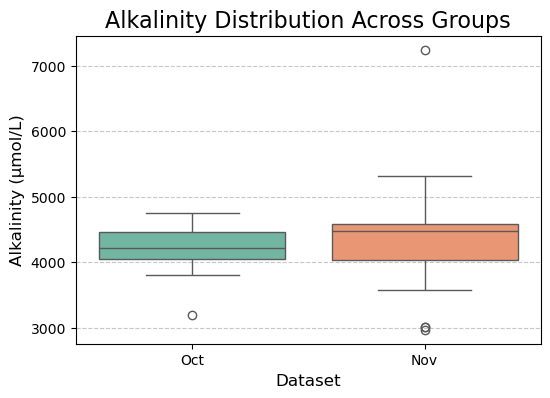

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot to compare the Alkalinity
plt.figure(figsize=(6, 4))
sns.boxplot(data=all_data, x='Dataset', y='Alkalinity (µmol/L)', palette='Set2')
plt.title('Alkalinity Distribution Across Groups', fontsize=16)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Alkalinity (μmol/L)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
from scipy.stats import ttest_ind
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Fillter the data
oct_data = all_data[all_data['Date'].dt.date == pd.to_datetime('2024-10-22').date()]['Alkalinity (µmol/L)']
nov_data = all_data[all_data['Date'].dt.date == pd.to_datetime('2024-11-12').date()]['Alkalinity (µmol/L)']


In [13]:
oct_data = oct_data.dropna()
nov_data = nov_data.dropna()

In [14]:
# t-Test
t_stat, p_value = ttest_ind(oct_data, nov_data, nan_policy='omit')

print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")
if p_value < 0.05:
    print("Alkalinity different")
else:
    print("no Alkalinity different")

T-statistic: -0.520, p-value: 0.605
no Alkalinity different


In [15]:
from scipy.spatial.distance import pdist, squareform

# Taking the coordinate
coords = all_data['geometry'].apply(lambda point: (point.x, point.y)).tolist()

# Calculated the distance by matrix
distance_matrix = squareform(pdist(coords))

# Change to DataFrame（便于可视化和操作）
import pandas as pd
distance_df = pd.DataFrame(distance_matrix, index=all_data.index, columns=all_data.index)

# Print out the results
print(distance_df.head())


         0          1          2          3          4          5    \
0   0.000000  82.169858  23.286981  27.956138  21.936180  44.593821   
1  82.169858   0.000000  59.223711  63.272124  60.242120  54.319442   
2  23.286981  59.223711   0.000000  21.318489   4.045566  33.037572   
3  27.956138  63.272124  21.318489   0.000000  17.377302  16.682509   
4  21.936180  60.242120   4.045566  17.377302   0.000000  29.934528   

         6          7           8           9    ...         177         178  \
0  67.897187  93.646419  103.414557  110.814176  ...  294.003112  301.738907   
1  17.289817  12.664215   23.243842   31.944034  ...  212.773001  220.215197   
2  45.931192  70.468949   80.155120   87.527341  ...  270.719599  278.470203   
3  46.720494  75.763069   86.224799   94.545855  ...  275.757978  283.008152   
4  46.145921  71.813112   81.699159   89.280961  ...  272.341402  280.004917   

          179        180        181        182        183        184  \
0  299.470231   1.35

In [16]:
threshold = 3.0  # Distance threshold
close_points = [(i, j) for i in distance_df.index for j in distance_df.index if i < j and distance_df.loc[i, j] <= threshold]

In [17]:
from scipy.stats import ttest_ind

results = []
for i, j in close_points:
    group1 = all_data.loc[i, 'DIC']
    group2 = all_data.loc[j, 'DIC']
    
    if pd.notna(group1) and pd.notna(group2):
        t_stat, p_value = ttest_ind([group1], [group2], equal_var=False)
        results.append({'Point1': i, 'Point2': j, 'T-statistic': t_stat, 'P-value': p_value})

# Change to DataFrame and see the results
results_df = pd.DataFrame(results)
print(results_df)


/Users/star/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/star/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


    Point1  Point2  T-statistic  P-value
0       26      78          NaN      NaN
1       28      29          NaN      NaN
2       28      30          NaN      NaN
3       28      31          NaN      NaN
4       28     112          NaN      NaN
5       29      30          NaN      NaN
6       29      31          NaN      NaN
7       29     112          NaN      NaN
8       30      31          NaN      NaN
9       30     112          NaN      NaN
10      31     112          NaN      NaN
11      58      59          NaN      NaN
12      58      60          NaN      NaN
13      58      61          NaN      NaN
14      59      60          NaN      NaN
15      59      61          NaN      NaN
16      60      61          NaN      NaN
17      71     128          NaN      NaN
18      71     131          NaN      NaN
19      92     145          NaN      NaN
20      96      97          NaN      NaN
21      98      99          NaN      NaN
22      98     102          NaN      NaN
23      98     1

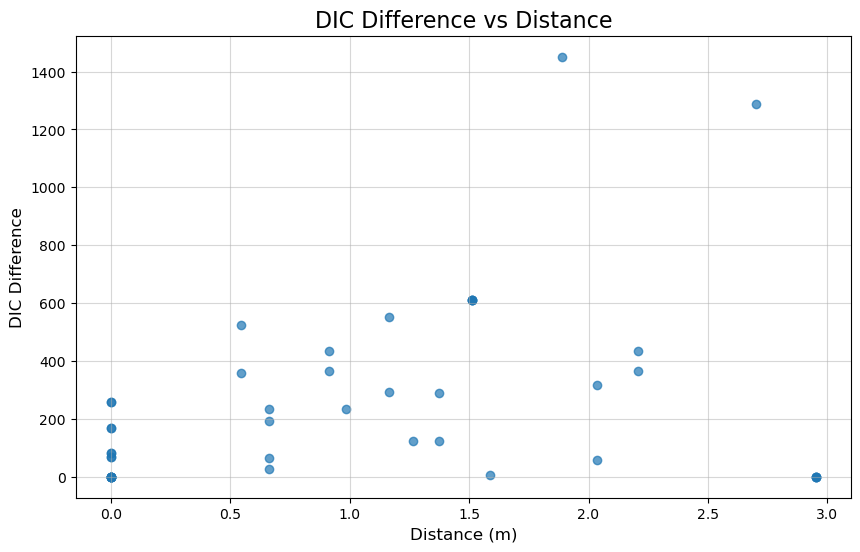

In [18]:
# Visualise the distance and the DIC difference
distance_values = [distance_df.loc[i, j] for i, j in close_points]
dic_differences = [abs(all_data.loc[i, 'DIC'] - all_data.loc[j, 'DIC']) for i, j in close_points]

plt.figure(figsize=(10, 6))
plt.scatter(distance_values, dic_differences, alpha=0.7)
plt.xlabel('Distance (m)', fontsize=12)
plt.ylabel('DIC Difference', fontsize=12)
plt.title('DIC Difference vs Distance', fontsize=16)
plt.grid(alpha=0.5)
plt.show()


In [19]:
all_data['Date'] = pd.to_datetime(all_data['Date'])
print(all_data['Date'])

0     2024-10-22 11:53:52.314
1     2024-11-12 11:09:00.721
2     2024-11-12 11:47:19.647
3     2024-11-12 11:51:30.347
4     2024-11-12 11:53:05.583
                ...          
182   2024-11-12 10:38:17.235
183   2024-11-12 10:51:48.223
184   2024-11-12 11:44:17.378
185   2024-11-12 11:51:40.266
186   2024-11-12 12:16:03.826
Name: Date, Length: 187, dtype: datetime64[ns]


#### Separate Oct & Nov, check how we could do the cluster

In [20]:
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data['Date_only'] = all_data['Date'].dt.date
oct_data = all_data[all_data['Date_only'] == pd.to_datetime('2024-10-22').date()]
nov_data = all_data[all_data['Date_only'] == pd.to_datetime('2024-11-12').date()]


Number of data points collected on 22-10-24: 89


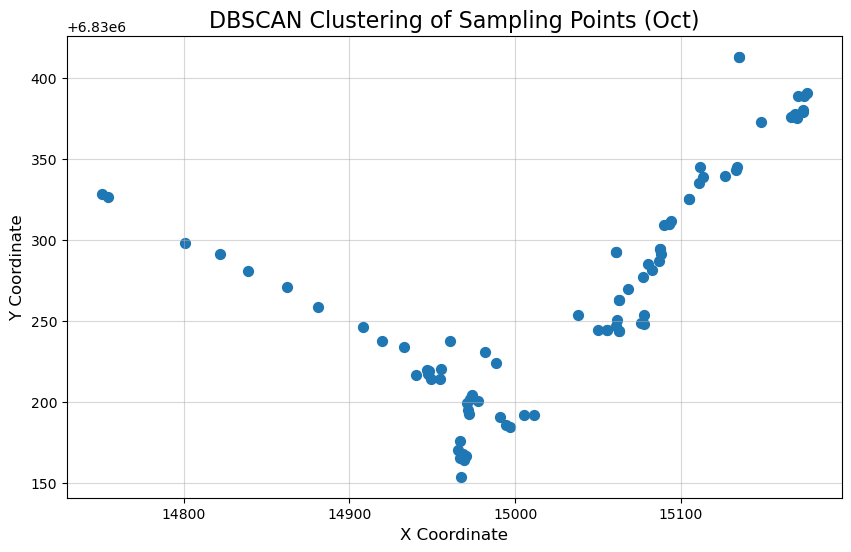

In [21]:
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data['Date_only'] = all_data['Date'].dt.date
oct_data = all_data[all_data['Date_only'] == pd.to_datetime('2024-10-22').date()]

x_coords = [point.x for point in oct_data['geometry']]
y_coords = [point.y for point in oct_data['geometry']]

print(f"Number of data points collected on 22-10-24: {len(oct_data)}")

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_coords, y_coords, #c=clusters, cmap='viridis',#
                      s=50)
#plt.colorbar(scatter, label='Cluster')
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.title('DBSCAN Clustering of Sampling Points (Oct)', fontsize=16)
plt.grid(alpha=0.5)
plt.show()


Number of data points collected on 12-11-24: 98


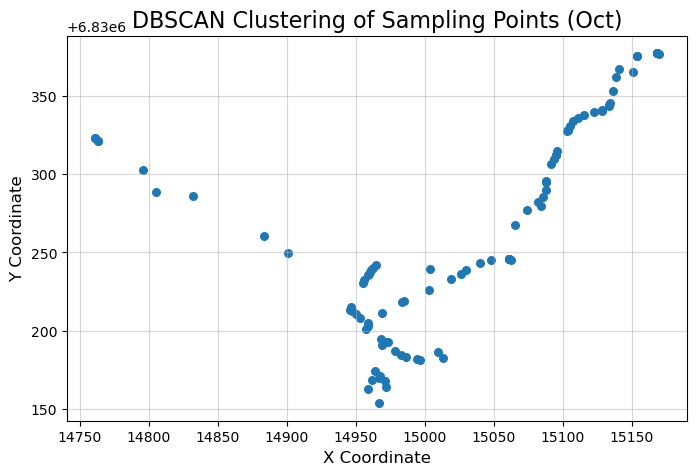

In [22]:
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data['Date_only'] = all_data['Date'].dt.date
nov_data = all_data[all_data['Date_only'] == pd.to_datetime('2024-11-12').date()]

x_coords = [point.x for point in nov_data['geometry']]
y_coords = [point.y for point in nov_data['geometry']]


print(f"Number of data points collected on 12-11-24: {len(nov_data)}")

plt.figure(figsize=(8, 5))
scatter = plt.scatter(x_coords, y_coords, #c=clusters, cmap='viridis',#
                      s=30)
#plt.colorbar(scatter, label='Cluster')
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.title('DBSCAN Clustering of Sampling Points (Oct)', fontsize=16)
plt.grid(alpha=0.5)
plt.show()


#### Save the dataframe

In [23]:
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data['Date_only'] = all_data['Date'].dt.date
oct_data = all_data[(all_data['Date_only'] == pd.to_datetime('2024-10-22').date()) & (all_data['Dataset'] != 'Nov')]
nov_data = all_data[(all_data['Date_only'] == pd.to_datetime('2024-11-12').date()) | (all_data['Dataset'] == 'Nov')]

# Save as CSV
oct_data.to_csv('Oct_data.csv', index=False)
nov_data.to_csv('Nov_data.csv', index=False)

#### Oct_data clustering

In [144]:
from sklearn.cluster import DBSCAN
oct_data = oct_data.copy()

# DBSCAN clustering
coords = oct_data['geometry'].apply(lambda point: (point.x, point.y)).tolist()
coords_array = np.array(coords)
db = DBSCAN(eps=10, min_samples=5, metric='euclidean').fit(coords_array)

# Add the results to DataFrame
oct_data['Cluster'] = db.labels_

print(oct_data[['geometry', 'Cluster']].head())
print(oct_data['Cluster'].value_counts())

                         geometry  Cluster
0   POINT (14970.098 6830166.545)        0
12  POINT (14966.545 6830176.038)        0
24   POINT (14971.05 6830199.303)        1
26  POINT (14971.851 6830192.838)        1
27  POINT (14949.449 6830214.029)        2
Cluster
-1    38
 3    11
 0     7
 2     7
 4     7
 1     6
 5     5
Name: count, dtype: int64


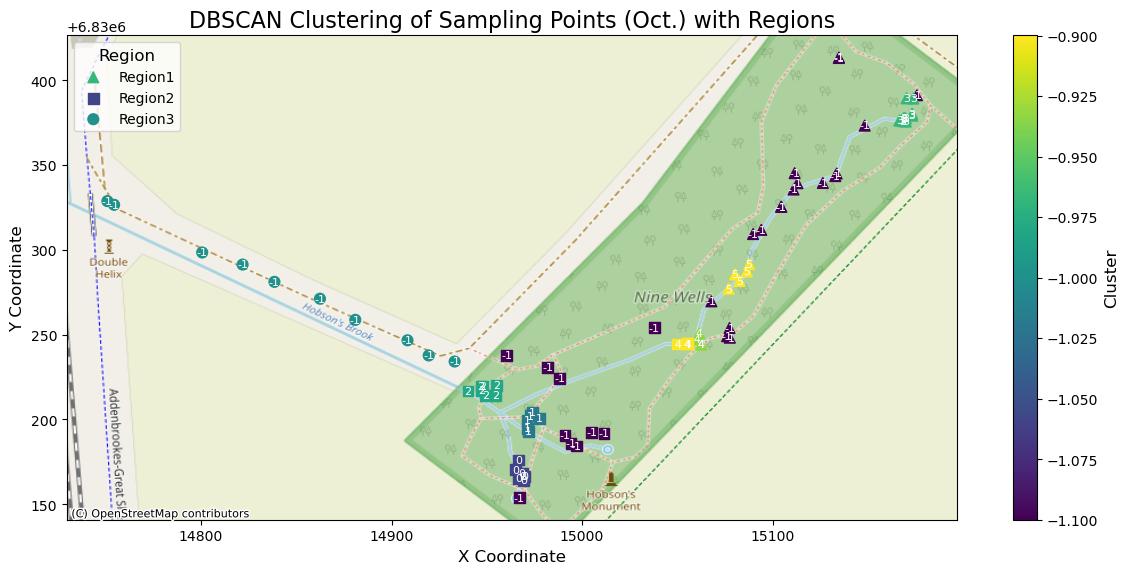

In [145]:
import matplotlib.pyplot as plt
import contextily as ctx

x_coords = [point.x for point in oct_data['geometry']]
y_coords = [point.y for point in oct_data['geometry']]
clusters = oct_data['Cluster']
regions = oct_data['Region']

# Set the shapes for different regions
region_shapes = {
    'Region1': '^',  
    'Region2': 's',  
    'Region3': 'o',  
}

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the regions
for region, shape in region_shapes.items():
    region_data = oct_data[oct_data['Region'] == region]
    x_region = [point.x for point in region_data['geometry']]
    y_region = [point.y for point in region_data['geometry']]
    cluster_region = region_data['Cluster']
    
    scatter = ax.scatter(
        x_region, y_region,
        c=cluster_region, cmap='viridis',
        marker=shape, s=60,
        label=region
    )

# Add colour bar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster', fontsize=12)


ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title('DBSCAN Clustering of Sampling Points (Oct.) with Regions', fontsize=16)

# Add the background
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend
ax.legend(title='Region', fontsize=10, title_fontsize=12)

for x, y, cluster in zip(x_coords, y_coords, clusters):
    ax.text(x, y, str(cluster), fontsize=8, ha='center', va='center', color='white')

plt.tight_layout()
plt.savefig('oct.png', dpi=300, bbox_inches='tight')
plt.show()


In [146]:
for i in oct_data['Cluster'].unique():
    print("Cluster " + str(i))
    cluster_i_oct_data = oct_data[oct_data['Cluster'] == i][['Temp', 'Alkalinity (µmol/L)', 'Dataset', 'DIC']]
    print(cluster_i_oct_data)

Cluster 0
     Temp  Alkalinity (µmol/L) Dataset          DIC
0     NaN            3198.1304     Oct          NaN
12   12.2            4232.6364     Oct  5006.531303
69    NaN                  NaN     NaN          NaN
154   NaN                  NaN     NaN          NaN
160  12.0                  NaN     NaN          NaN
161  12.0                  NaN     NaN          NaN
172   NaN                  NaN     NaN          NaN
Cluster 1
     Temp  Alkalinity (µmol/L) Dataset          DIC
24    NaN            4121.7636     Oct          NaN
26   12.6            3996.8960     Oct  4622.286669
74   12.7            3981.3200     Oct  4207.285245
75   12.6            3809.0400     Oct  4204.033692
159  11.9                  NaN     NaN          NaN
162  12.1                  NaN     NaN          NaN
Cluster 2
     Temp  Alkalinity (µmol/L) Dataset          DIC
27    NaN            3836.6402     Oct          NaN
35   11.8                  NaN     NaN          NaN
52   12.3            4170.1200    

In [147]:
for i in range(4):  
    cluster_i_oct_data = oct_data[oct_data['Cluster'] == i]
    temp_values = cluster_i_oct_data['Temp'].dropna()
    print(f"Cluster {i}: Temp Values: {temp_values.tolist()}")

Cluster 0: Temp Values: [12.2, 12.0, 12.0]
Cluster 1: Temp Values: [12.6, 12.7, 12.6, 11.9, 12.1]
Cluster 2: Temp Values: [11.8, 12.3, 11.3, 11.8]
Cluster 3: Temp Values: [12.2, 12.2, 12.4, 12.3, 12.4]


In [148]:
for i in range(4):
    cluster_i_oct_data = oct_data[oct_data['Cluster'] == i]
    temp_values = cluster_i_oct_data['Temp'].dropna()
    print(f"Cluster {i}: Mean: {temp_values.mean()}, Std Dev: {temp_values.std()}")

Cluster 0: Mean: 12.066666666666668, Std Dev: 0.11547005383792475
Cluster 1: Mean: 12.379999999999999, Std Dev: 0.35637059362410894
Cluster 2: Mean: 11.8, Std Dev: 0.408248290463863
Cluster 3: Mean: 12.299999999999999, Std Dev: 0.10000000000000053


#### Nov_data analysis

In [33]:
# Create a copy of the original dataset
nov_data = nov_data.copy()

# DBSCAN clustering
coords = nov_data['geometry'].apply(lambda point: (point.x, point.y)).tolist()
coords_array = np.array(coords)
db = DBSCAN(eps=10, min_samples=5, metric='euclidean').fit(coords_array)

# Add the result to the DataFrame
nov_data['Cluster'] = db.labels_

# Visualise the result
print(nov_data[['geometry', 'Cluster']].head())
print(nov_data['Cluster'].value_counts())

                        geometry  Cluster
1  POINT (15018.776 6830232.744)       -1
2  POINT (14986.462 6830183.113)        5
3   POINT (14968.408 6830194.45)        5
4   POINT (14982.67 6830184.522)        5
5  POINT (14968.945 6830211.124)       -1
Cluster
-1    34
 0    10
 2     8
 9     8
 8     8
 5     7
 1     7
 3     7
 6     7
 4     5
 7     5
Name: count, dtype: int64


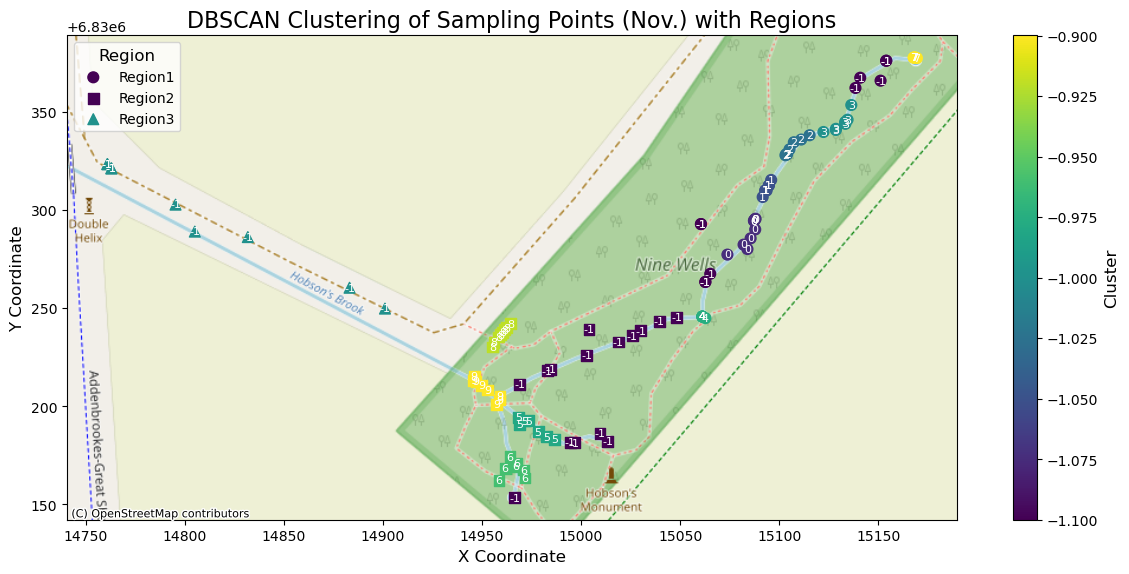

In [139]:
import matplotlib.pyplot as plt
import contextily as ctx

x_coords = [point.x for point in nov_data['geometry']]
y_coords = [point.y for point in nov_data['geometry']]
clusters = nov_data['Cluster']
regions = nov_data['Region']  

# Set the shapes for different regions
region_shapes = {
    'Region1': 'o',  
    'Region2': 's',  
    'Region3': '^', 
}

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the graph
for region, shape in region_shapes.items():
    region_data = nov_data[nov_data['Region'] == region]
    x_region = [point.x for point in region_data['geometry']]
    y_region = [point.y for point in region_data['geometry']]
    cluster_region = region_data['Cluster']
    
    scatter = ax.scatter(
        x_region, y_region,
        c=cluster_region, cmap='viridis',
        marker=shape, s=60,
        label=region
    )

# Add colour bar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster', fontsize=12)

# Add labels
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title('DBSCAN Clustering of Sampling Points (Nov.) with Regions', fontsize=16)

# Add background figure
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend
ax.legend(title='Region', fontsize=10, title_fontsize=12)


for x, y, cluster in zip(x_coords, y_coords, clusters):
    ax.text(x, y, str(cluster), fontsize=8, ha='center', va='center', color='white')

plt.tight_layout()
plt.savefig('nov.png', dpi=300, bbox_inches='tight')
plt.show()


In [35]:
for i in nov_data['Cluster'].unique():
    print("Cluster " + str(i))
    cluster_i_nov_data = nov_data[nov_data['Cluster'] == i][['Temp', 'Alkalinity (µmol/L)', 'Dataset', 'DIC']]
    print(cluster_i_nov_data)

Cluster -1
     Temp  Alkalinity (µmol/L) Dataset          DIC
1    11.4          2969.434600     Nov  3332.458538
5    11.3                  NaN     NaN          NaN
6    11.3                  NaN     NaN          NaN
7    11.3                  NaN     NaN          NaN
8    11.3                  NaN     NaN          NaN
9    11.4                  NaN     NaN          NaN
10   11.4                  NaN     NaN          NaN
25   11.5                  NaN     NaN          NaN
32   11.4                  NaN     Nov          NaN
34   11.5          3011.525200     Nov  3360.985582
42   11.4                  NaN     NaN          NaN
48   11.2                  NaN     NaN          NaN
49   11.1                  NaN     NaN          NaN
50   11.1                  NaN     NaN          NaN
51   11.3                  NaN     NaN          NaN
53   11.0          4247.909482     Nov  4639.959224
58   11.0          4912.541630     Nov  5365.932187
59   11.0          4912.541630     Nov  5365.932187
6

#### Conduct t-tests

In [36]:
for i in range(7):  # 假设有 4 个簇
    cluster_i_nov_data = nov_data[nov_data['Cluster'] == i]
    temp_values = cluster_i_nov_data['Temp'].dropna()
    print(f"Cluster {i}: Temp Values: {temp_values.tolist()}")

Cluster 0: Temp Values: [11.4, 11.3, 11.4, 11.4, 11.2, 11.8, 11.9, 11.6, 12.1, 12.1]
Cluster 1: Temp Values: [11.4, 11.4, 11.6, 12.2, 12.2, 11.6, 11.6]
Cluster 2: Temp Values: [11.5, 11.5, 11.5, 11.5, 11.3, 11.9, 11.5, 11.5]
Cluster 3: Temp Values: [11.5, 11.5, 11.5, 11.5, 11.5, 11.8, 11.7]
Cluster 4: Temp Values: [11.2, 11.2, 11.2, 11.2, 11.7]
Cluster 5: Temp Values: [11.3, 11.2, 11.2, 11.9, 11.5, 11.5, 11.7]
Cluster 6: Temp Values: [11.7, 11.5, 11.6, 11.6, 11.5, 11.9]


In [37]:
for i in range(7):
    cluster_i_nov_data = nov_data[nov_data['Cluster'] == i]
    temp_values = cluster_i_nov_data['Temp'].dropna()
    print(f"Cluster {i}: Mean: {temp_values.mean()}, Std Dev: {temp_values.std()}")


Cluster 0: Mean: 11.62, Std Dev: 0.33266599866332386
Cluster 1: Mean: 11.714285714285712, Std Dev: 0.34364987719368945
Cluster 2: Mean: 11.525, Std Dev: 0.166904592079256
Cluster 3: Mean: 11.571428571428571, Std Dev: 0.12535663410560186
Cluster 4: Mean: 11.3, Std Dev: 0.22360679774997896
Cluster 5: Mean: 11.471428571428572, Std Dev: 0.262769136406122
Cluster 6: Mean: 11.633333333333333, Std Dev: 0.1505545305418163


#### Chemical variables

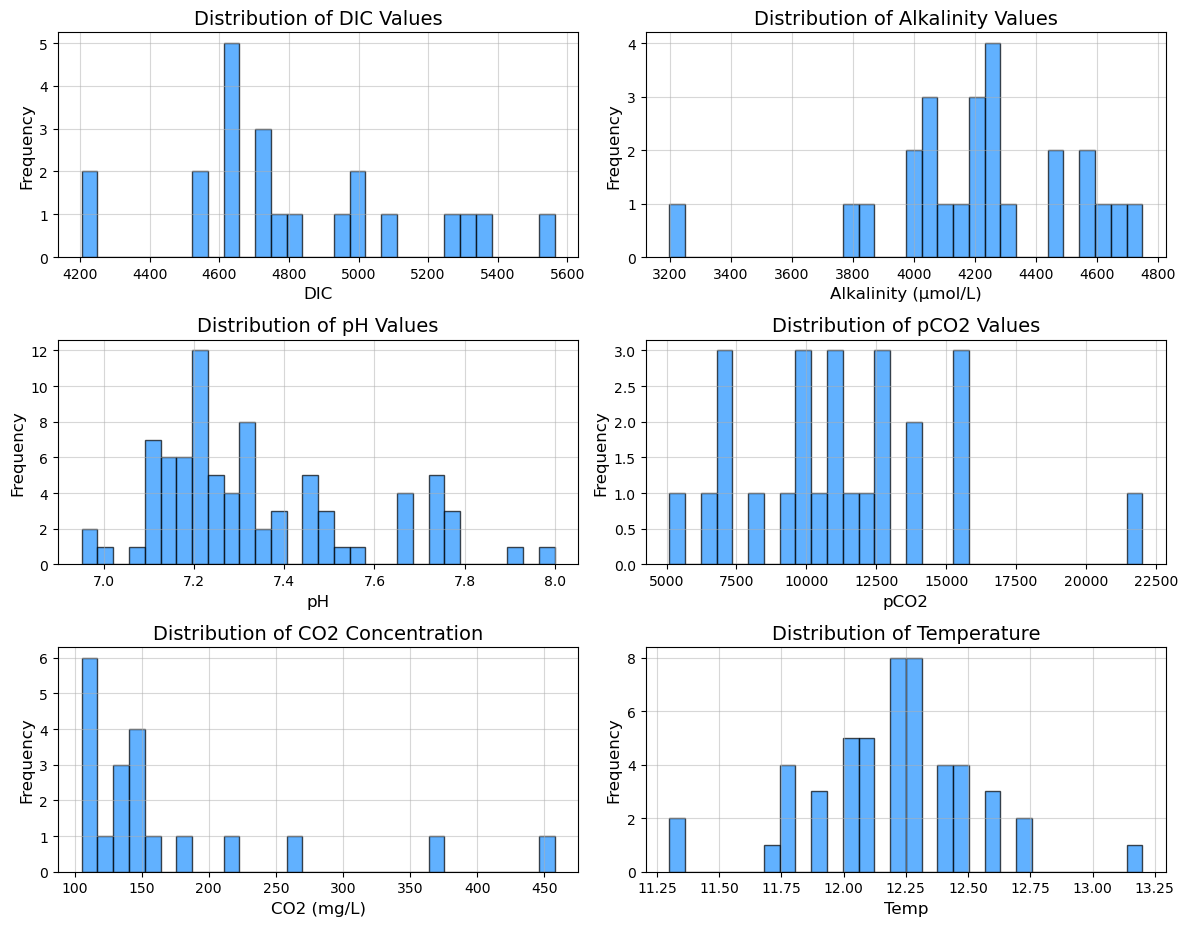

In [150]:
# List of variables to plot
variables = ['DIC', 'Alkalinity (µmol/L)', 'pH', 'pCO2', 'CO2 (mg/L)', 'Temp']
titles = {
    'DIC': 'Distribution of DIC Values',
    'Alkalinity (µmol/L)': 'Distribution of Alkalinity Values',
    'pH': 'Distribution of pH Values',
    'pCO2': 'Distribution of pCO2 Values',
    'CO2 (mg/L)': 'Distribution of CO2 Concentration',
    'Temp': 'Distribution of Temperature'
}

# Set up subplots (3 rows, 3 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()

# Loop through each variable and create a histogram
for i, variable in enumerate(variables):
    ax = axes[i]
    ax.hist(oct_data[variable].dropna(), bins=30, color='dodgerblue', edgecolor='k', alpha=0.7)
    ax.set_xlabel(variable, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(titles[variable], fontsize=14)
    ax.grid(alpha=0.5)

# Hide unused subplots (if any)
for j in range(len(variables), len(axes)):
    axes[j].set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('chemical_distributions.png', dpi=300, bbox_inches='tight')  # Save as a high-quality PNG
plt.show()


## Regression anlaysis

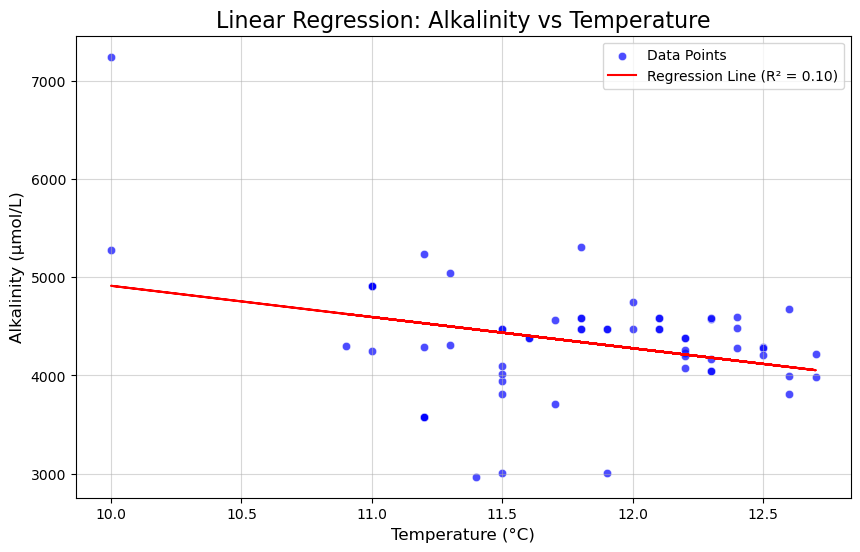

In [38]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Select relevant columns for the analysis (replace with actual column names)
# Example: Exploring the relationship between Alkalinity and Temp
data = all_data.dropna(subset=['Alkalinity (µmol/L)', 'Temp'])  # Remove rows with missing values

# Define variables
X = data[['Temp']].values  # Independent variable (e.g., Temp)
y = data['Alkalinity (µmol/L)'].values  # Dependent variable (e.g., Alkalinity)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Calculate R-squared value
r2 = r2_score(y, y_pred)

# Plot the data and the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Temp'], y=data['Alkalinity (µmol/L)'], color='blue', label='Data Points', alpha=0.7)
plt.plot(data['Temp'], y_pred, color='red', label=f'Regression Line (R² = {r2:.2f})')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Alkalinity (µmol/L)', fontsize=12)
plt.title('Linear Regression: Alkalinity vs Temperature', fontsize=16)
plt.legend()
plt.grid(alpha=0.5)
plt.show()


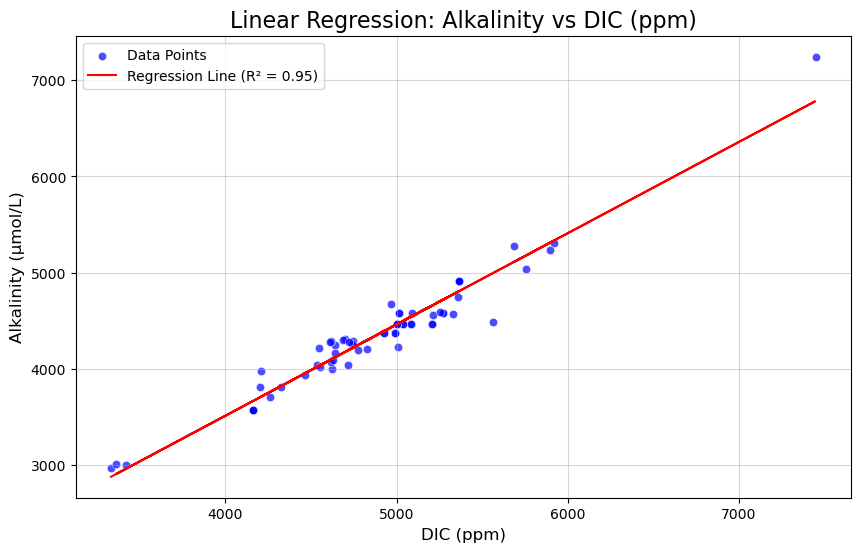

In [39]:
data = all_data.dropna(subset=['Alkalinity (µmol/L)', 'DIC'])  # Remove rows with missing values

# Define variables
X = data[['DIC']].values  # Independent variable (e.g., Temp)
y = data['Alkalinity (µmol/L)'].values  # Dependent variable (e.g., Alkalinity)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Calculate R-squared value
r2 = r2_score(y, y_pred)

# Plot the data and the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['DIC'], y=data['Alkalinity (µmol/L)'], color='blue', label='Data Points', alpha=0.7)
plt.plot(data['DIC'], y_pred, color='red', label=f'Regression Line (R² = {r2:.2f})')
plt.xlabel('DIC (ppm)', fontsize=12)
plt.ylabel('Alkalinity (µmol/L)', fontsize=12)
plt.title('Linear Regression: Alkalinity vs DIC (ppm)', fontsize=16)
plt.legend()
plt.grid(alpha=0.5)
plt.show()


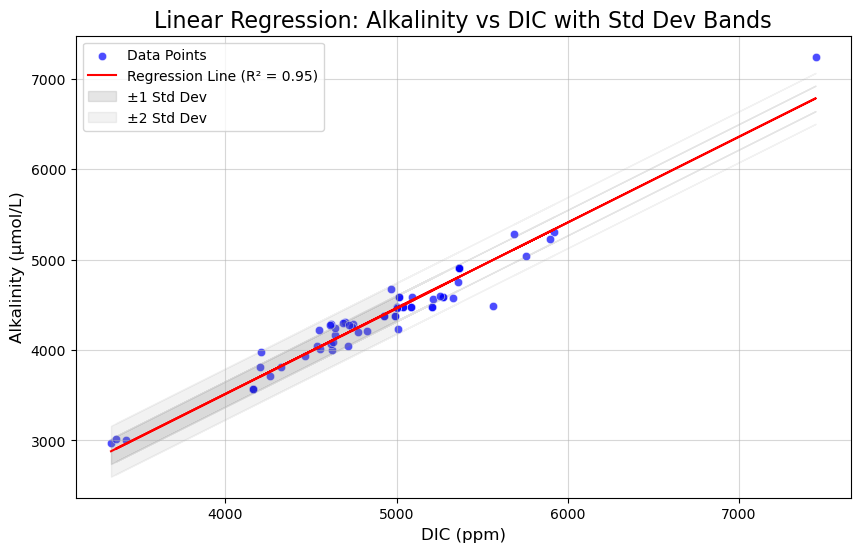

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Remove rows with missing values for the required columns
data = all_data.dropna(subset=['Alkalinity (µmol/L)', 'DIC'])

# Define variables
X = data[['DIC']].values  # Independent variable
y = data['Alkalinity (µmol/L)'].values  # Dependent variable

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Calculate R-squared value
r2 = r2_score(y, y_pred)

# Calculate standard deviation of residuals
residuals = y - y_pred
std_dev = np.std(residuals)

# Plot the data, regression line, and standard deviation bands
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['DIC'], y=data['Alkalinity (µmol/L)'], color='blue', label='Data Points', alpha=0.7)
plt.plot(data['DIC'], y_pred, color='red', label=f'Regression Line (R² = {r2:.2f})')

# Add standard deviation bands
plt.fill_between(data['DIC'], y_pred - std_dev, y_pred + std_dev, color='gray', alpha=0.2, label='±1 Std Dev')
plt.fill_between(data['DIC'], y_pred - 2*std_dev, y_pred + 2*std_dev, color='gray', alpha=0.1, label='±2 Std Dev')

# Add labels and title
plt.xlabel('DIC (ppm)', fontsize=12)
plt.ylabel('Alkalinity (µmol/L)', fontsize=12)
plt.title('Linear Regression: Alkalinity vs DIC with Std Dev Bands', fontsize=16)
plt.legend()
plt.grid(alpha=0.5)

# Show the plot
plt.show()


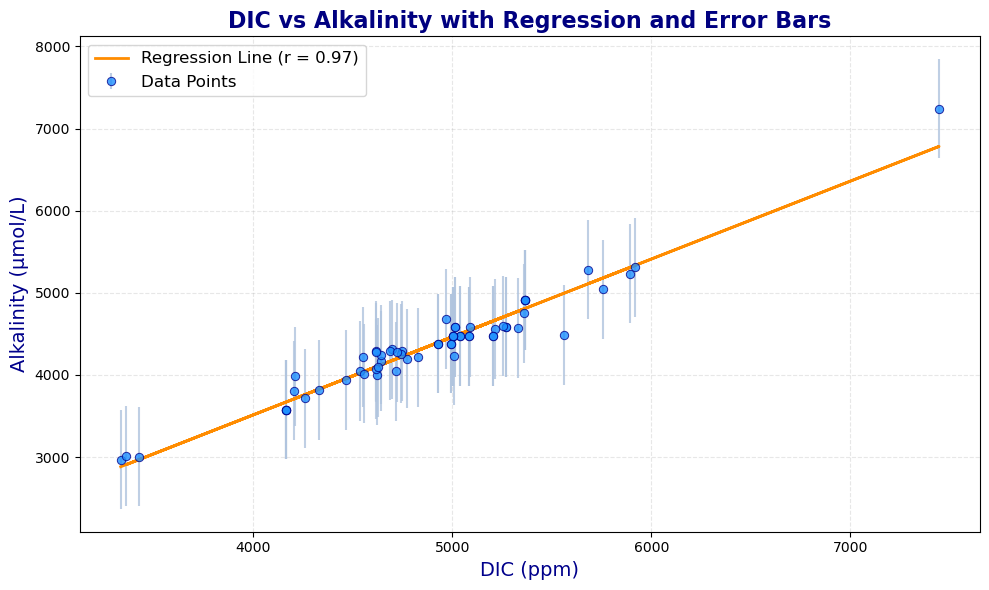

In [41]:
# Improved visualization with updated colors and aesthetics

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Preparing data
data = all_data.dropna(subset=['Alkalinity (µmol/L)', 'DIC'])  # Ensure no missing values
x = data['DIC']
y = data['Alkalinity (µmol/L)']
y_err = data['Alkalinity Error'] if 'Alkalinity Error' in data.columns else np.std(y)  # Assume error column exists or use std

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
y_pred = slope * x + intercept  # Regression line

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot with error bars (updated color scheme)
plt.errorbar(
    x, y, yerr=y_err, fmt='o', color='dodgerblue', ecolor='lightsteelblue', alpha=0.8, label='Data Points',
    markeredgewidth=0.7, markeredgecolor='darkblue'
)

# Regression line
plt.plot(x, y_pred, color='darkorange', linewidth=2, label=f'Regression Line (r = {r_value:.2f})')

# Add grid and improve aesthetics
plt.grid(alpha=0.3, linestyle='--', linewidth=0.8)

# Add labels and title
plt.title('DIC vs Alkalinity with Regression and Error Bars', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('DIC (ppm)', fontsize=14, color='darkblue')
plt.ylabel('Alkalinity (µmol/L)', fontsize=14, color='darkblue')

# Add legend with better placement
plt.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.8)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


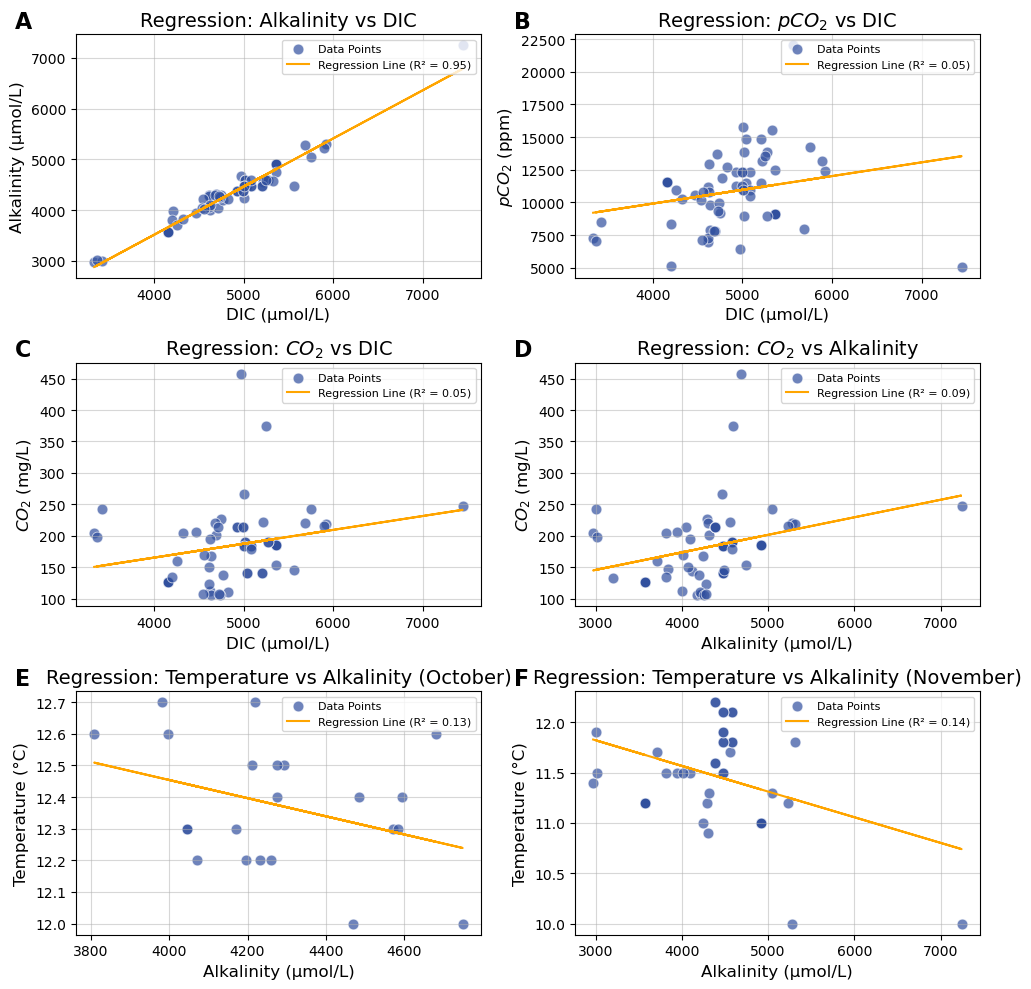

In [91]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Define the pairs of variables for regression
pairs = [
    ('DIC', 'Alkalinity (µmol/L)'),  # (1,1)
    ('DIC', 'pCO2'),                # (1,2)
    ('DIC', 'CO2 (mg/L)'),          # (2,1)
    ('Alkalinity (µmol/L)', 'CO2 (mg/L)'),  # (2,2)
    ('Alkalinity (µmol/L)', 'Temp', 'oct_data'),  # (3,1)
    ('Alkalinity (µmol/L)', 'Temp', 'nov_data')   # (3,2)
]

# Define labels with proper subscripts
labels = {
    'DIC': 'DIC (µmol/L)',
    'pCO2': '$pCO_2$ (ppm)',
    'CO2 (mg/L)': '$CO_2$ (mg/L)',
    'Alkalinity (µmol/L)': 'Alkalinity (µmol/L)',
    'Temp': 'Temperature (°C)'
}
subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F']
    
# Set up the subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 10))  # 3 rows x 2 columns
axes = axes.flatten()  # Flatten axes for easier indexing

# Iterate through pairs and create regression plots
for idx, pair in enumerate(pairs):
    x_var, y_var = pair[:2]
    data_key = pair[2] if len(pair) > 2 else 'all_data'

    # Select the appropriate dataset
    if data_key == 'oct_data':
        data = oct_data.dropna(subset=[x_var, y_var])
        title_suffix = ' (October)'
    elif data_key == 'nov_data':
        data = nov_data.dropna(subset=[x_var, y_var])
        title_suffix = ' (November)'
    else:
        data = all_data.dropna(subset=[x_var, y_var])
        title_suffix = ''

    # Define variables for regression
    X = data[[x_var]].values
    y = data[y_var].values

    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict values and calculate R-squared
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Plot the data and regression line
    ax = axes[idx]
    sns.scatterplot(x=data[x_var], y=data[y_var], s=60, ax=ax, color='#304f9e', label='Data Points', alpha=0.7)
    ax.plot(data[x_var], y_pred, color='orange', label=f'Regression Line (R² = {r2:.2f})', alpha=1)

    # Set labels and title
    ax.set_xlabel(labels[x_var], fontsize=12)
    ax.set_ylabel(labels[y_var], fontsize=12)
    ax.set_title(f'Regression: {labels[y_var].split(" (")[0]} vs {labels[x_var].split(" (")[0]}{title_suffix}', fontsize=14)
    ax.legend(loc='upper right', fontsize = 8)
    ax.grid(alpha=0.5)

    # Add subplot label
    ax.text(-0.15, 1.1, subplot_labels[idx], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('regression_subplots.png', dpi=300, bbox_inches='tight')
plt.show()

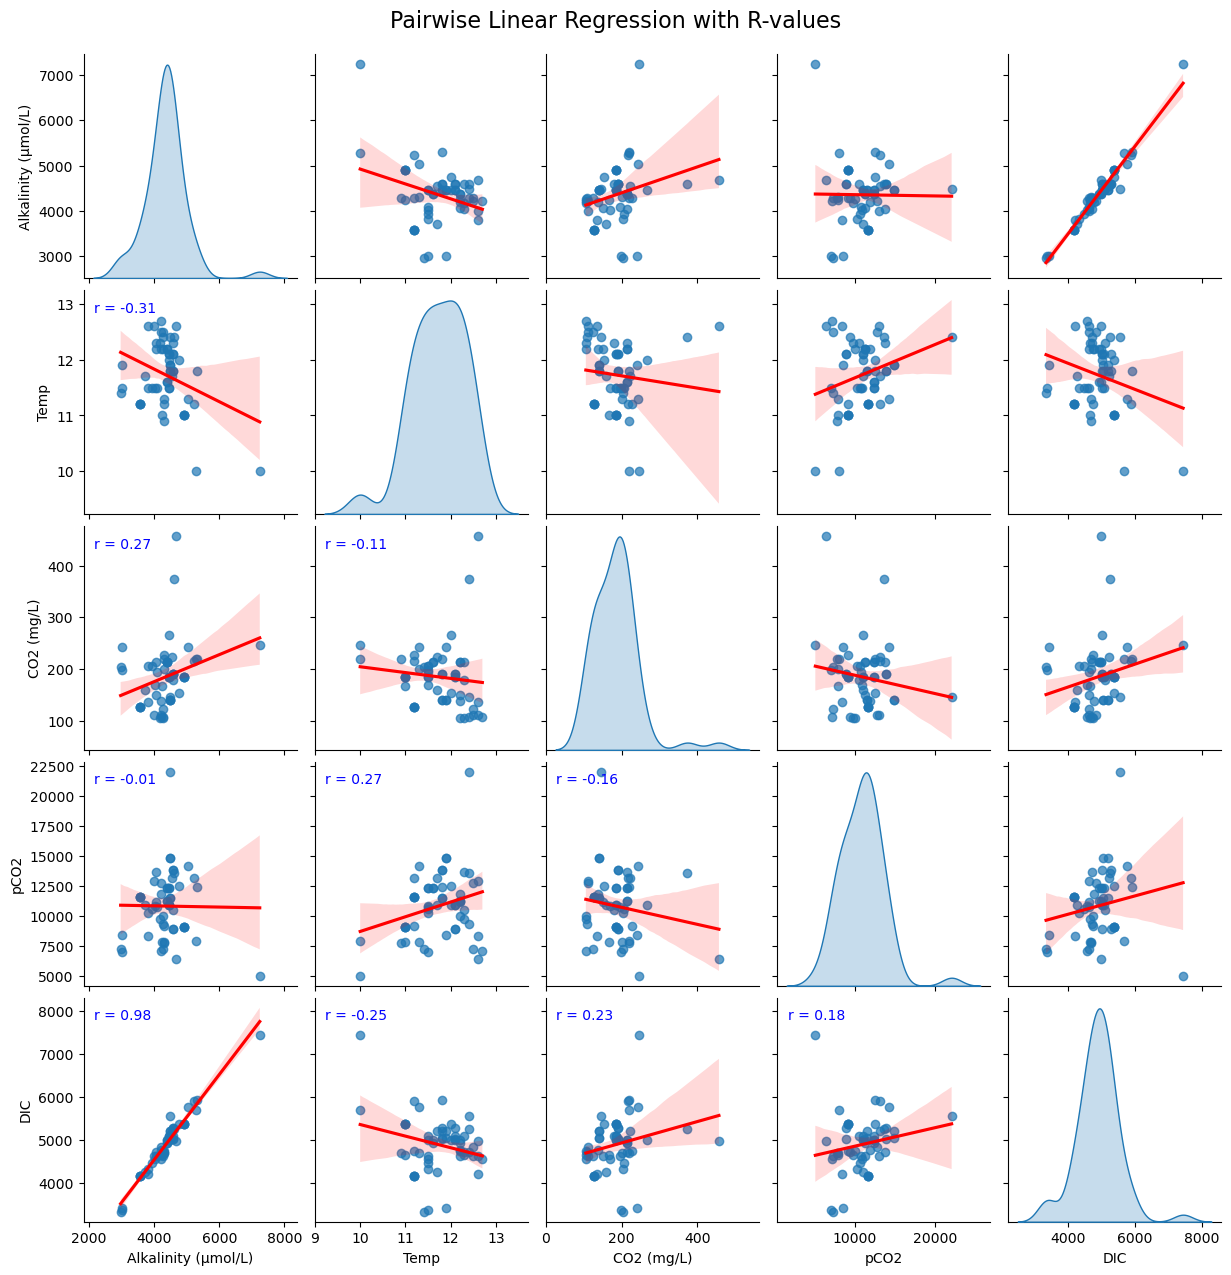

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Function to calculate and annotate r-value on plots
def annotate_r_value(x, y, **kwargs):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    ax = plt.gca()
    ax.annotate(f'r = {r_value:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                ha='left', va='top', fontsize=10, color='blue')

# Select numerical columns for analysis
numerical_columns = ['Alkalinity (µmol/L)', 'Temp', 'CO2 (mg/L)', 'pCO2', 'DIC']  # Replace with your dataset's numerical columns
data = all_data[numerical_columns].dropna()  # Drop rows with missing values

# Pairplot with linear regression lines and r-value annotations
g = sns.pairplot(data, kind='reg', diag_kind='kde', 
                 plot_kws={'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.7}})

# Add r-value annotations
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        if i > j:  # Only annotate on the upper triangle
            x = data[numerical_columns[j]]
            y = data[numerical_columns[i]]
            plt.sca(ax)
            annotate_r_value(x, y)

plt.suptitle('Pairwise Linear Regression with R-values', y=1.02, fontsize=16)
plt.show()


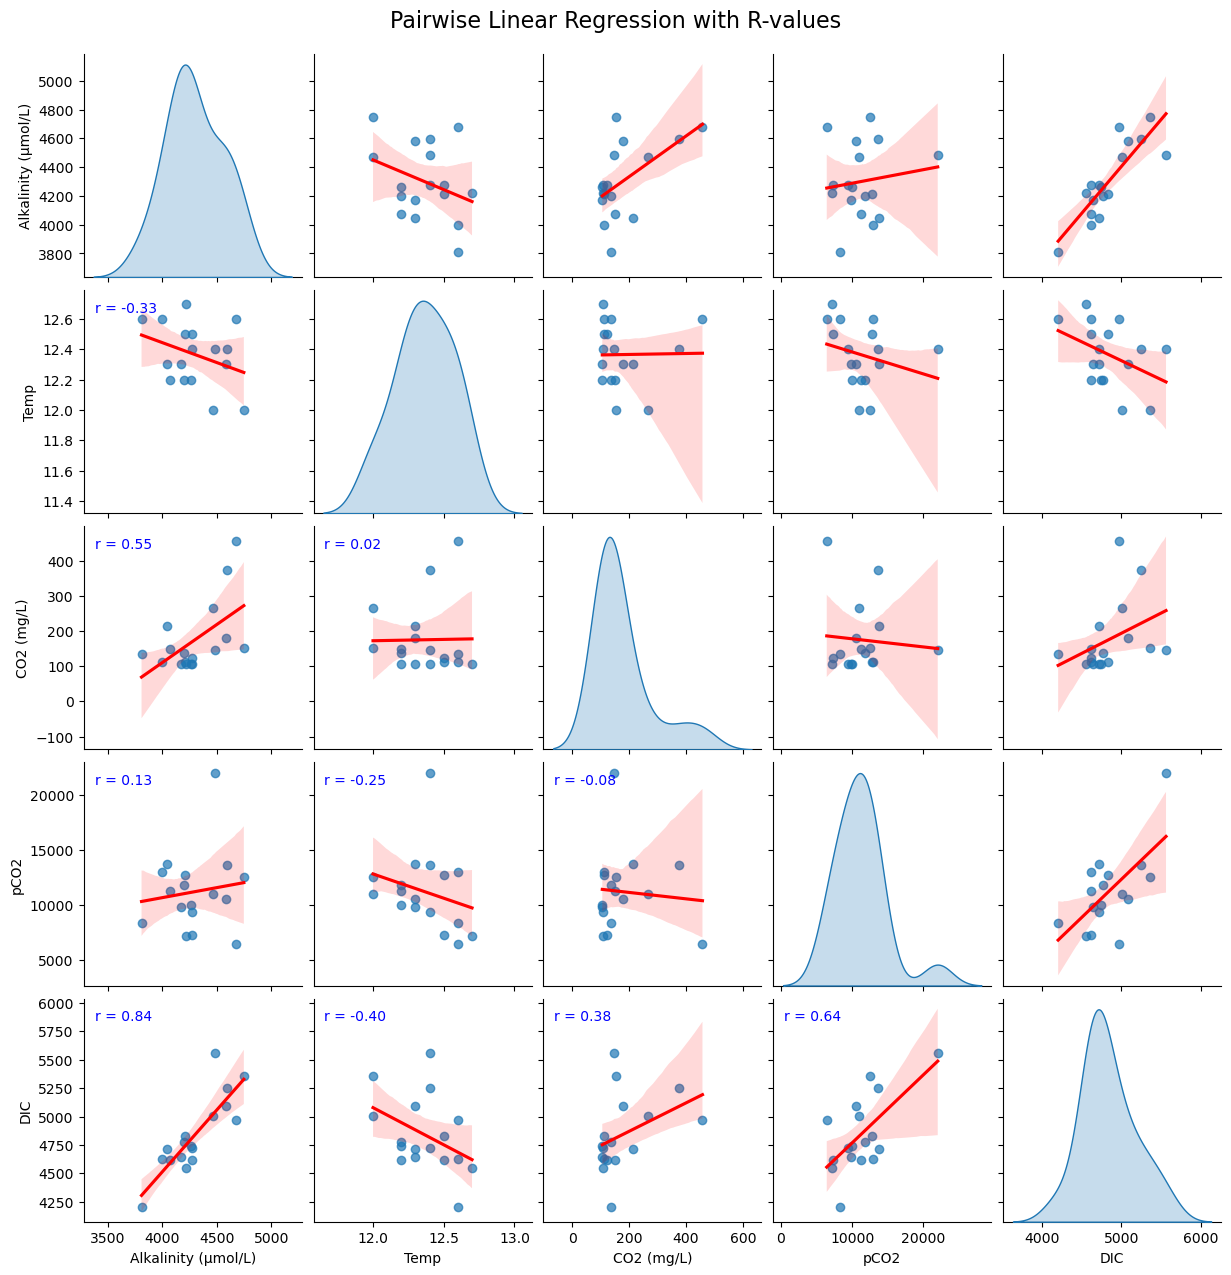

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Function to calculate and annotate r-value on plots
def annotate_r_value(x, y, **kwargs):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    ax = plt.gca()
    ax.annotate(f'r = {r_value:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                ha='left', va='top', fontsize=10, color='blue')

# Select numerical columns for analysis
numerical_columns = ['Alkalinity (µmol/L)', 'Temp', 'CO2 (mg/L)', 'pCO2', 'DIC']  # Replace with your dataset's numerical columns
data = oct_data[numerical_columns].dropna()  # Drop rows with missing values

# Pairplot with linear regression lines and r-value annotations
g = sns.pairplot(data, kind='reg', diag_kind='kde', 
                 plot_kws={'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.7}})

# Add r-value annotations
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        if i > j:  # Only annotate on the upper triangle
            x = data[numerical_columns[j]]
            y = data[numerical_columns[i]]
            plt.sca(ax)
            annotate_r_value(x, y)

plt.suptitle('Pairwise Linear Regression with R-values', y=1.02, fontsize=16)
plt.show()

## Analysis by different quantaties
### Alkalinity

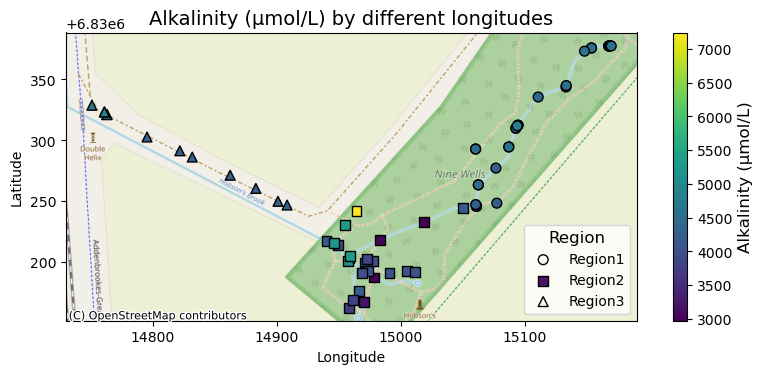

<Figure size 640x480 with 0 Axes>

In [47]:
import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Set the shapes for different regions
region_shapes = {
    'Region1': 'o',  
    'Region2': 's',  
    'Region3': '^',  
}


vmin, vmax = all_data['Alkalinity (µmol/L)'].min(), all_data['Alkalinity (µmol/L)'].max()
cmap = plt.cm.viridis  

# Plot the data over all regions
for region, shape in region_shapes.items():
    region_data = all_data[all_data['Region'] == region]
    sc = ax.scatter(
        region_data.geometry.x, region_data.geometry.y,
        c=region_data['Alkalinity (µmol/L)'],  
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        edgecolor='k',  
        marker=shape,  
        s=50,  
        label=region 
    )


ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Alkalinity (µmol/L)', fontsize=12)
ax.legend(title='Region', fontsize=10, title_fontsize=12)
ax.set_title('Alkalinity (µmol/L) by different longitudes', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Alkalinity (µmol/L)', fontsize=12)

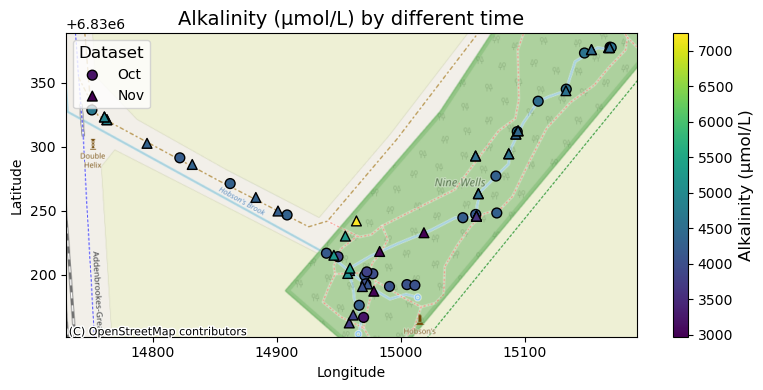

<Figure size 640x480 with 0 Axes>

In [48]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Set the shapes for different regions
Dataset_shapes = {
    'Oct': 'o',  
    'Nov': '^',  
}


vmin, vmax = all_data['Alkalinity (µmol/L)'].min(), all_data['Alkalinity (µmol/L)'].max()
cmap = plt.cm.viridis  

# Plot the data over all regions
for Dataset, shape in Dataset_shapes.items():
    Dataset_data = all_data[all_data['Dataset'] == Dataset]
    sc = ax.scatter(
        Dataset_data.geometry.x, Dataset_data.geometry.y,
        c=Dataset_data['Alkalinity (µmol/L)'],
        cmap=cmap,
        vmin=vmin, vmax=vmax, 
        edgecolor='k',
        marker=shape,
        s=50, 
        label=Dataset  
    )


ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Alkalinity (µmol/L)', fontsize=12)
ax.legend(title='Dataset', fontsize=10, title_fontsize=12)
ax.set_title('Alkalinity (µmol/L) by different time', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Alkalinity (µmol/L)', fontsize=12)

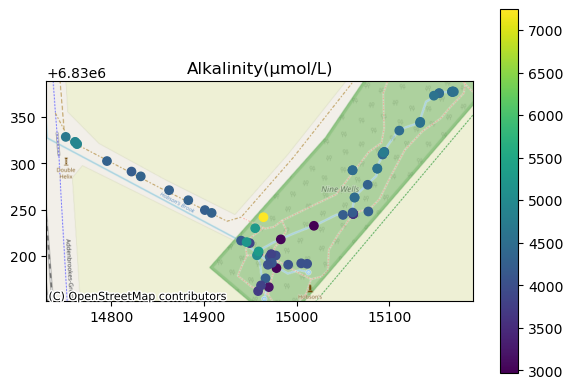

In [49]:
import contextily as ctx
fig, ax = plt.subplots(figsize=(6,4))
all_data.plot(column='Alkalinity (µmol/L)', legend=True,ax=ax)
ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('Alkalinity(µmol/L)')
plt.tight_layout()

In [50]:
merged_data['Longitude'] = all_data['geometry'].x
merged_data['Latitude'] = all_data['geometry'].y

In [51]:
print(merged_data.columns)

Index(['Group', 'Sample ID (as in QField)', 'Alkalinity (µmol/L)',
       'CO2 (mg/L)', 'Unnamed: 4', 'Dataset', 'Corrected alkalinity (Y/N)',
       'Longitude', 'Latitude'],
      dtype='object')


### CO2

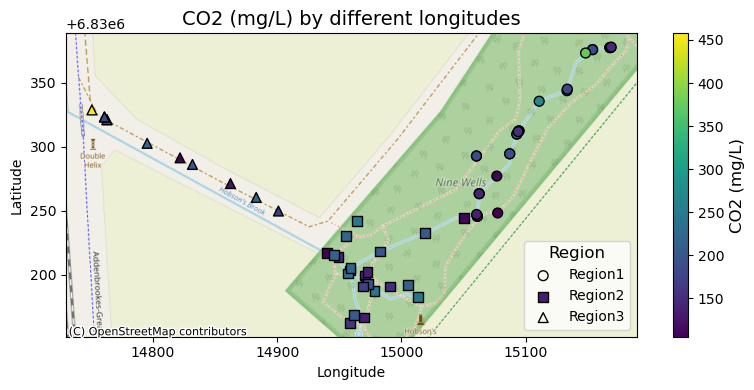

<Figure size 640x480 with 0 Axes>

In [52]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Set the shapes for different regions
region_shapes = {
    'Region1': 'o',  
    'Region2': 's',  
    'Region3': '^',  
}


vmin, vmax = all_data['CO2 (mg/L)'].min(), all_data['CO2 (mg/L)'].max()
cmap = plt.cm.viridis  

# Plot the data over all regions
for region, shape in region_shapes.items():
    region_data = all_data[all_data['Region'] == region]
    sc = ax.scatter(
        region_data.geometry.x, region_data.geometry.y,
        c=region_data['CO2 (mg/L)'], 
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        edgecolor='k',  
        marker=shape, 
        s=50,  
        label=region  
    )


ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('CO2 (mg/L)', fontsize=12)
ax.legend(title='Region', fontsize=10, title_fontsize=12)
ax.set_title('CO2 (mg/L) by different longitudes', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('CO2 (mg/L)', fontsize=12)

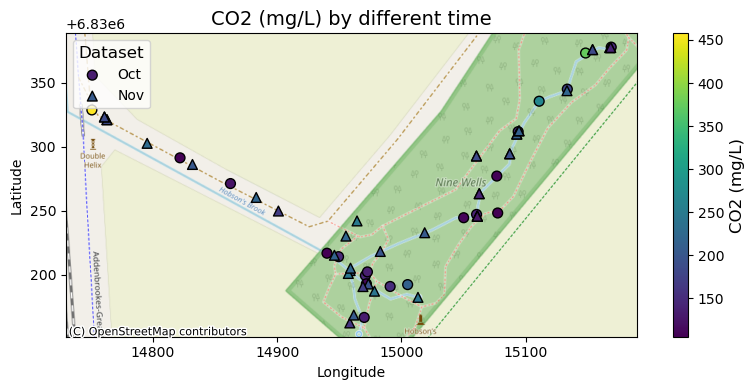

<Figure size 640x480 with 0 Axes>

In [53]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Set the shapes for different regions
Dataset_shapes = {
    'Oct': 'o', 
    'Nov': '^', 
}


vmin, vmax = all_data['CO2 (mg/L)'].min(), all_data['CO2 (mg/L)'].max()
cmap = plt.cm.viridis  

# Plot the data over all regions
for Dataset, shape in Dataset_shapes.items():
    Dataset_data = all_data[all_data['Dataset'] == Dataset]
    sc = ax.scatter(
        Dataset_data.geometry.x, Dataset_data.geometry.y,
        c=Dataset_data['CO2 (mg/L)'],  
        cmap=cmap,
        vmin=vmin, vmax=vmax, 
        edgecolor='k',  
        marker=shape,  
        s=50, 
        label=Dataset  
    )


ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('CO2 (mg/L)', fontsize=12)
ax.legend(title='Dataset', fontsize=10, title_fontsize=12)
ax.set_title('CO2 (mg/L) by different time', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('CO2 (mg/L)', fontsize=12)

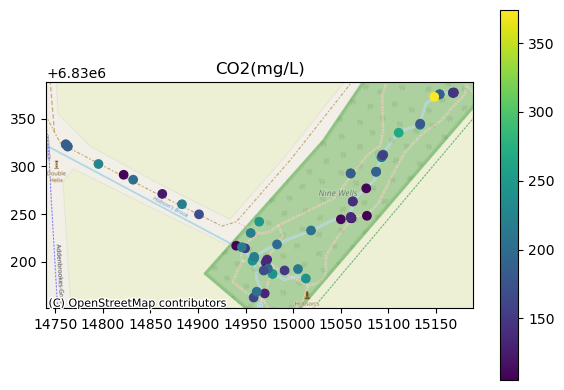

In [54]:
fig, ax = plt.subplots(figsize=(6,4))
ind = all_data['CO2 (mg/L)'] < 400
all_data.loc[ind].plot(column='CO2 (mg/L)', legend=True, ax=ax)
ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('CO2(mg/L)')
plt.tight_layout()

### pCO2

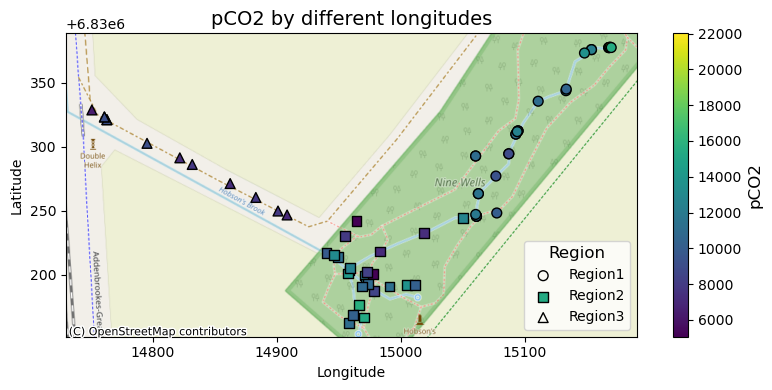

<Figure size 640x480 with 0 Axes>

In [55]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Set the shapes for different regions
region_shapes = {
    'Region1': 'o',  
    'Region2': 's',  
    'Region3': '^',
}


vmin, vmax = all_data['pCO2'].min(), all_data['pCO2'].max()
cmap = plt.cm.viridis

# Plot the data over all regions
for region, shape in region_shapes.items():
    region_data = all_data[all_data['Region'] == region]
    sc = ax.scatter(
        region_data.geometry.x, region_data.geometry.y,
        c=region_data['pCO2'],  
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        edgecolor='k', 
        marker=shape,  
        s=50, 
        label=region  
    )


ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('pCO2', fontsize=12)
ax.legend(title='Region', fontsize=10, title_fontsize=12)
ax.set_title('pCO2 by different longitudes', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('pCO2', fontsize=12)

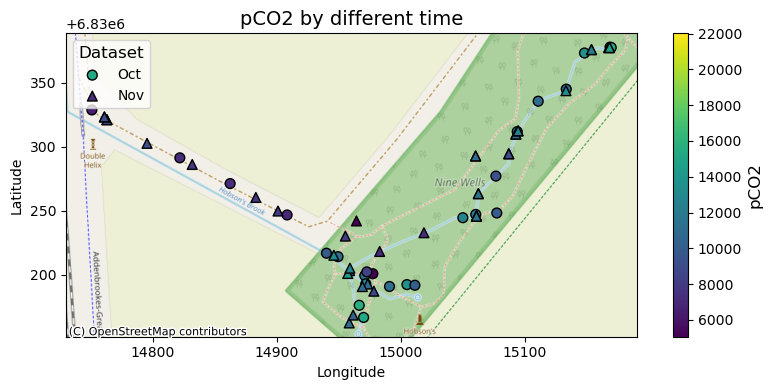

<Figure size 640x480 with 0 Axes>

In [56]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Set the shapes for different regions
Dataset_shapes = {
    'Oct': 'o',  
    'Nov': '^',  
}


vmin, vmax = all_data['pCO2'].min(), all_data['pCO2'].max()
cmap = plt.cm.viridis  

# Plot the data over all regions
for Dataset, shape in Dataset_shapes.items():
    Dataset_data = all_data[all_data['Dataset'] == Dataset]
    sc = ax.scatter(
        Dataset_data.geometry.x, Dataset_data.geometry.y,
        c=Dataset_data['pCO2'], 
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        edgecolor='k',  
        marker=shape,  
        s=50, 
        label=Dataset  
    )


ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([]) 
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('pCO2', fontsize=12)
ax.legend(title='Dataset', fontsize=10, title_fontsize=12)
ax.set_title('pCO2 by different time', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('pCO2', fontsize=12)

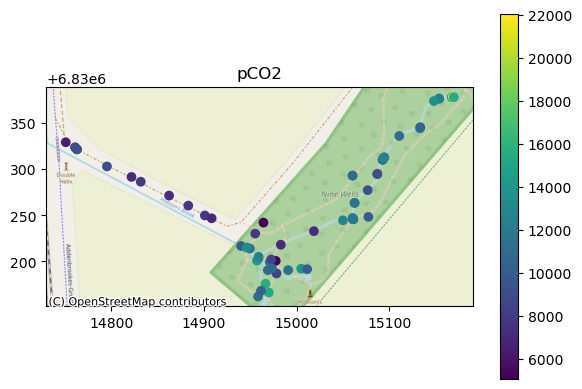

In [57]:
import contextily as ctx
fig, ax = plt.subplots(figsize=(6,4))
all_data.plot(column='pCO2', legend=True,ax=ax)
ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('pCO2')
plt.tight_layout()

### DIC

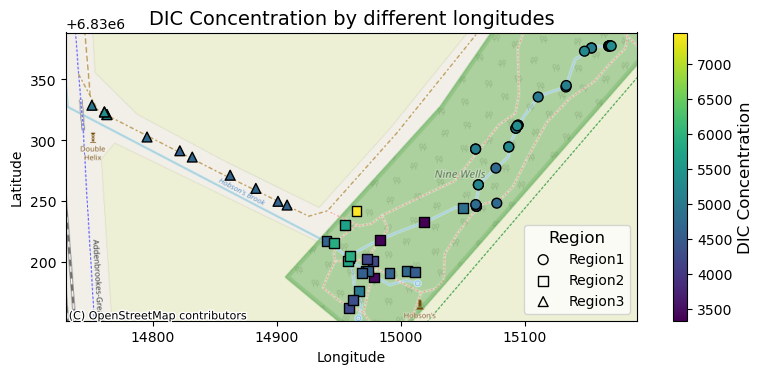

<Figure size 640x480 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import matplotlib as mpl

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Set the shapes for different regions
region_shapes = {
    'Region1': 'o',  
    'Region2': 's',  
    'Region3': '^',  
}


vmin, vmax = all_data['DIC'].min(), all_data['DIC'].max()
cmap = plt.cm.viridis  

# Plot the data over all regions
for region, shape in region_shapes.items():
    region_data = all_data[all_data['Region'] == region]
    sc = ax.scatter(
        region_data.geometry.x, region_data.geometry.y,
        c=region_data['DIC'],  
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        edgecolor='k',
        marker=shape,  
        s=50, 
        label=region  
    )


ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('DIC Concentration', fontsize=12)
ax.legend(title='Region', fontsize=10, title_fontsize=12)
ax.set_title('DIC Concentration by different longitudes', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('DIC Concentration', fontsize=12)


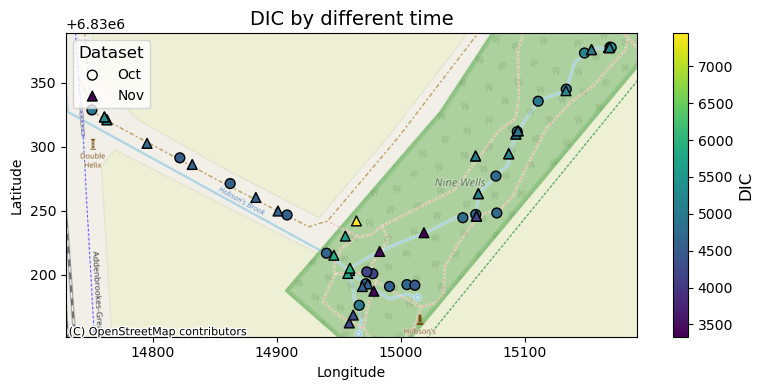

<Figure size 640x480 with 0 Axes>

In [59]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Set the shapes for different regions
Dataset_shapes = {
    'Oct': 'o', 
    'Nov': '^', 
}


vmin, vmax = all_data['DIC'].min(), all_data['DIC'].max()
cmap = plt.cm.viridis  

# Plot the data over all regions
for Dataset, shape in Dataset_shapes.items():
    Dataset_data = all_data[all_data['Dataset'] == Dataset]
    sc = ax.scatter(
        Dataset_data.geometry.x, Dataset_data.geometry.y,
        c=Dataset_data['DIC'],  
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        edgecolor='k',  
        marker=shape, 
        s=50, 
        label=Dataset 
    )


ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('DIC', fontsize=12)
ax.legend(title='Dataset', fontsize=10, title_fontsize=12)
ax.set_title('DIC by different time', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('DIC', fontsize=12)

## DIC-TA

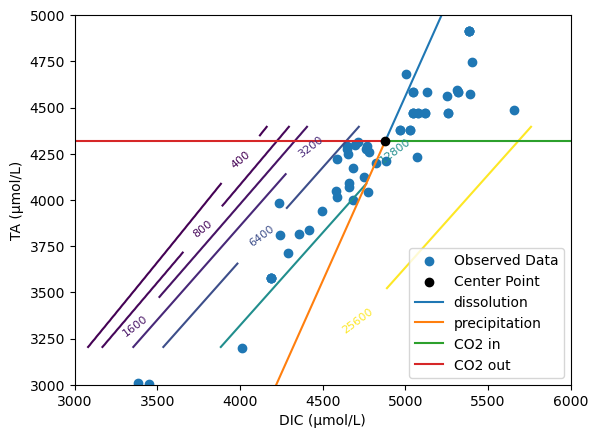

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import cbsyst as cb

# Set the range od  DIC and TA
TA = np.linspace(3200, 4400, 100)
DIC = np.linspace(3000, 6000, 100)
xTA, yDIC = np.meshgrid(TA, DIC)

# Calculate
cs = cb.Csys(TA=xTA, DIC=yDIC, S_in=0, T_in=10)
cs_data = cb.Csys(TA=all_data['Alkalinity (µmol/L)'], pHNBS=all_data['pH'], S_in=0, T_in=10)

#center point
center_DIC = all_data.DIC.mean()
#center_TA = np.nanmean(all_data.TA)
center_TA = np.nanmean(all_data['Alkalinity (µmol/L)']) 


# Plot the scatter data
plt.scatter(cs_data.DIC, cs_data.TA, label='Observed Data')

# Plot the contour
cns = plt.contour(cs.DIC, cs.TA, cs.pCO2, levels=[400, 800, 1600, 3200, 6400, 12800, 25600])
plt.clabel(cns, inline=True, fontsize=8)

# Plot a center
plt.scatter(center_DIC, center_TA, color='k', zorder=999, label='Center Point')

# Dissolution and precipitation 
dDIC = 2000
stoic_calc = 2
stoic_resp = 0

# Using the center
plt.plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_calc], label='dissolution')
plt.plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_calc], label='precipitation')

# CO2 in and CO2 out 
plt.plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_resp], label='CO2 in')
plt.plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_resp], label='CO2 out')
plt.legend()
plt.xlim(3000, 6000)
plt.ylim(3000, 5000)
plt.xlabel('DIC (µmol/L)')
plt.ylabel('TA (µmol/L)')
plt.show()

In [64]:
all_data['Region'] = 'Region1'  
all_data.loc[all_data['geometry'].x < 14935, 'Region'] = 'Region3'
all_data.loc[(all_data['geometry'].x >= 14935) & (all_data['geometry'].x < 15050), 'Region'] = 'Region2'
all_data.loc[all_data['geometry'].x >= 15050, 'Region'] = 'Region1'

In [65]:
# Ensure the TDS data is ready to use
all_data['TDS (ppm)'] = pd.to_numeric(all_data['TDS (ppm)'], errors='coerce')

if all_data['TDS (ppm)'].isna().any():
    print("Warning: Some TDS (ppm) values were non-numeric and have been set to NaN.")
    print(all_data[all_data['TDS (ppm)'].isna()])

vmin, vmax = all_data['TDS (ppm)'].min(), all_data['TDS (ppm)'].max()
print(f"TDS (ppm) range: min = {vmin}, max = {vmax}")

       pH        SampleID  Temp  EC                    Date  \
34   7.30           AOJE9  11.5 NaN 2024-11-12 10:59:19.598   
65    NaN      CO2-FLUX-1   NaN NaN 2024-11-12 10:30:22.153   
66    NaN      CO2-FLUX-2   NaN NaN 2024-11-12 11:30:14.424   
67    NaN      CO2-FLUX-3   NaN NaN 2024-11-12 12:00:54.602   
68    NaN      CO2-FLUX-4   NaN NaN 2024-11-12 12:09:21.673   
152  7.19  SAMPLE2,371PPM   NaN NaN 2024-10-22 11:00:27.785   
171  7.19            None   NaN NaN 2024-10-22 11:01:23.179   
175  7.20            None   NaN NaN 2024-10-22 11:20:32.092   

                          geometry Group  Alkalinity (µmol/L)  CO2 (mg/L)  \
34   POINT (14983.039 6830218.095)  AOJE            3011.5252       197.7   
65   POINT (14966.414 6830153.454)   NaN                  NaN         NaN   
66   POINT (14966.953 6830169.503)   NaN                  NaN         NaN   
67   POINT (14805.088 6830288.887)   NaN                  NaN         NaN   
68    POINT (14984.584 6830218.76)   NaN       

/var/folders/bp/z1dm6g75717g8kp117hv2ykr0000gn/T/ipykernel_1009/2338718601.py:84: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = region_data.geometry.unary_union.centroid  # Compute centroid
/var/folders/bp/z1dm6g75717g8kp117hv2ykr0000gn/T/ipykernel_1009/2338718601.py:84: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = region_data.geometry.unary_union.centroid  # Compute centroid
/var/folders/bp/z1dm6g75717g8kp117hv2ykr0000gn/T/ipykernel_1009/2338718601.py:84: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = region_data.geometry.unary_union.centroid  # Compute centroid
/var/folders/bp/z1dm6g75717g8kp117hv2ykr0000gn/T/ipykernel_1009/2338718601.py:84: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = region_data.geometry.unary_uni

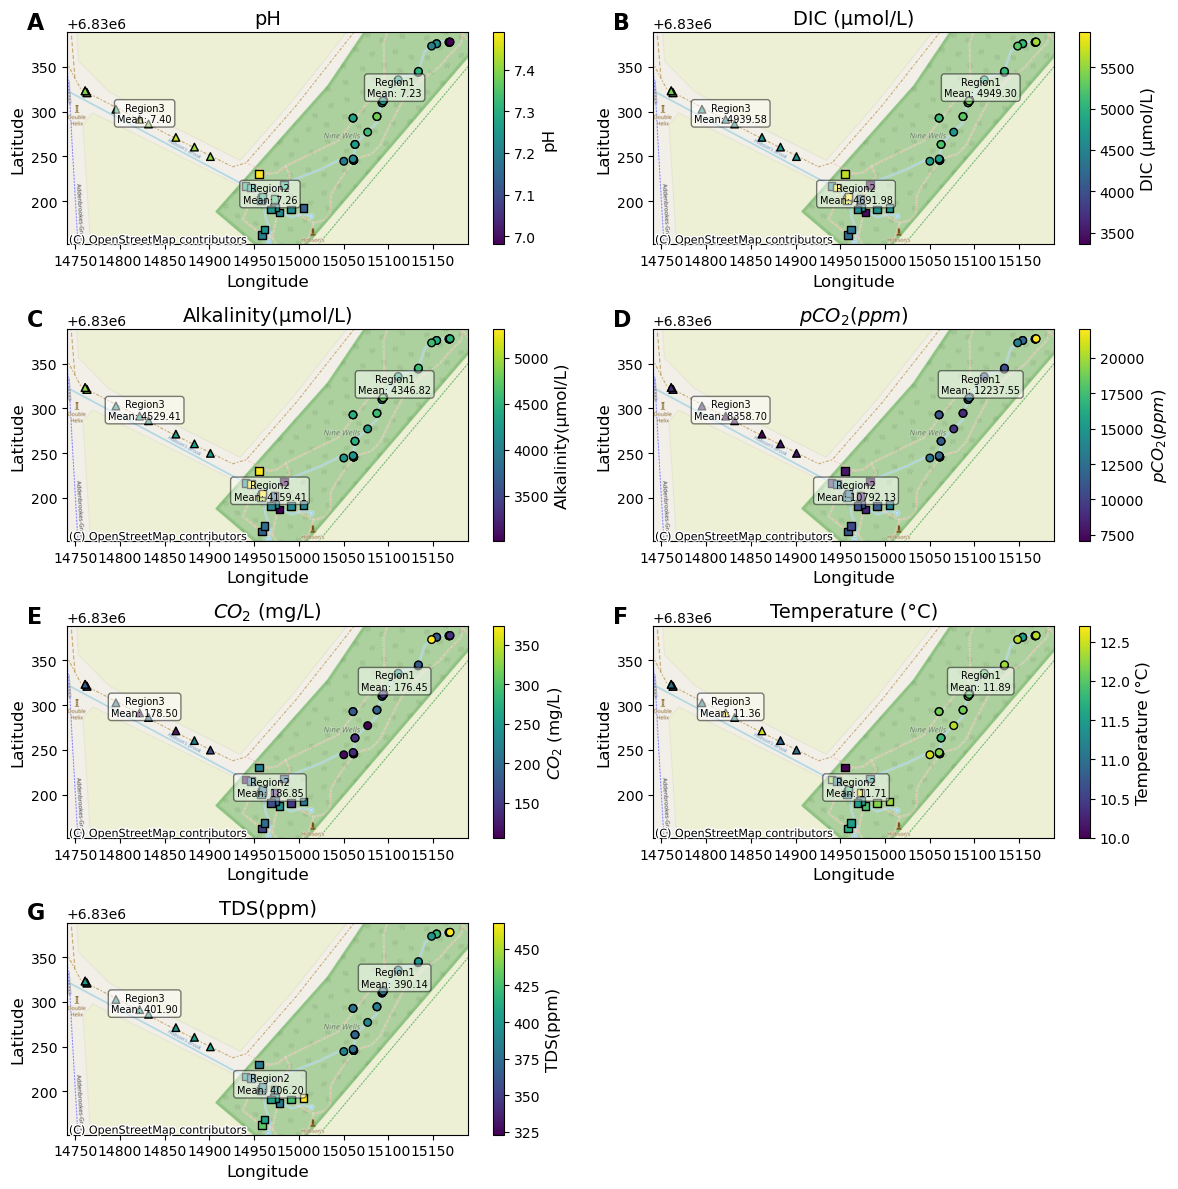

In [80]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as ctx

units = {
    'pH': '',
    'DIC': 'µmol/L',
    'Alkalinity (µmol/L)': 'µmol/L',
    'pCO2': 'ppm',
    'CO2 (mg/L)': 'mg/L',
    'Temp': '°C',
    'TDS (ppm)': 'ppm'
}

# List of variables to plot
variables = ['pH', 'DIC', 'Alkalinity (µmol/L)', 'pCO2', 'CO2 (mg/L)', 'Temp', 'TDS (ppm)']
titles = {
    'pH': 'pH',
    'DIC': 'DIC (µmol/L)',
    'Alkalinity (µmol/L)': 'Alkalinity(µmol/L)',
    'pCO2': '$pCO_2(ppm)$', 
    'CO2 (mg/L)': '$CO_2$ (mg/L)',  
    'Temp': 'Temperature (°C)',
    'TDS (ppm)': 'TDS(ppm)'
}

region_shapes = {
    'Region1': 'o',  # Circle
    'Region2': 's',  # Square
    'Region3': '^'   # Triangle
}

# Subplot labels
subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# Define thresholds for outlier removal (adjust based on your data distribution)
DIC_threshold = (all_data['DIC'].quantile(0.01), all_data['DIC'].quantile(0.99))
Alkalinity_threshold = (all_data['Alkalinity (µmol/L)'].quantile(0.01), all_data['Alkalinity (µmol/L)'].quantile(0.99))
CO2_threshold = (all_data['CO2 (mg/L)'].quantile(0.01), all_data['CO2 (mg/L)'].quantile(0.99))

# Filter data to remove outliers
filtered_data = all_data[
    (all_data['DIC'] >= DIC_threshold[0]) & (all_data['DIC'] <= DIC_threshold[1]) &
    (all_data['Alkalinity (µmol/L)'] >= Alkalinity_threshold[0]) & 
    (all_data['Alkalinity (µmol/L)'] <= Alkalinity_threshold[1]) &
    (all_data['CO2 (mg/L)'] >= CO2_threshold[0]) & (all_data['CO2 (mg/L)'] <= CO2_threshold[1])
]

# Set up subplots for all variables on one figure
fig, axes = plt.subplots(4, 2, figsize=(12, 12))  # Adjust rows/cols based on the number of variables
axes = axes.flatten()

for i, variable in enumerate(variables):
    ax = axes[i]
    
    # Add subplot label
    ax.text(-0.1, 1.1, subplot_labels[i], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')

    # Set the value range for color mapping
    vmin, vmax = filtered_data[variable].min(), filtered_data[variable].max()
    cmap = plt.cm.viridis

    # Plot data points for each region
    for region, shape in region_shapes.items():
        region_data = filtered_data[filtered_data['Region'] == region]
        sc = ax.scatter(
            region_data.geometry.x, region_data.geometry.y,
            c=region_data[variable],  # Use the variable for color
            cmap=cmap,
            vmin=vmin, vmax=vmax,
            edgecolor='k',
            marker=shape,
            s=30,
            label=region
        )

    # Calculate mean for the variable by region
    average_by_region = filtered_data.groupby('Region')[variable].mean()

    # Annotate the mean values on the plot
    for region, mean_value in average_by_region.items():
        region_data = filtered_data[filtered_data['Region'] == region]
        centroid = region_data.geometry.unary_union.centroid  # Compute centroid
    
        ax.text(
            centroid.x, centroid.y,
            f'{region}\nMean: {mean_value:.2f}',
            fontsize=7,
            ha='center', color='black',
            bbox=dict(facecolor='white', alpha=0.5, boxstyle='round')
        )
        
        
    # Add basemap
    ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
    # Add colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # Required to generate the colorbar
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(titles[variable], fontsize=12) 
    
    # Add title and axis labels
    ax.set_title(f'{titles[variable]}', fontsize=14)
    ax.set_xlabel('Longitude', fontsize=12)  
    ax.set_ylabel('Latitude', fontsize=12)  

# Hide unused subplots if the number of variables is less than grid size
for j in range(len(variables), len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('Region_Plot_with_Labels.png', dpi=300, bbox_inches='tight')
plt.show()


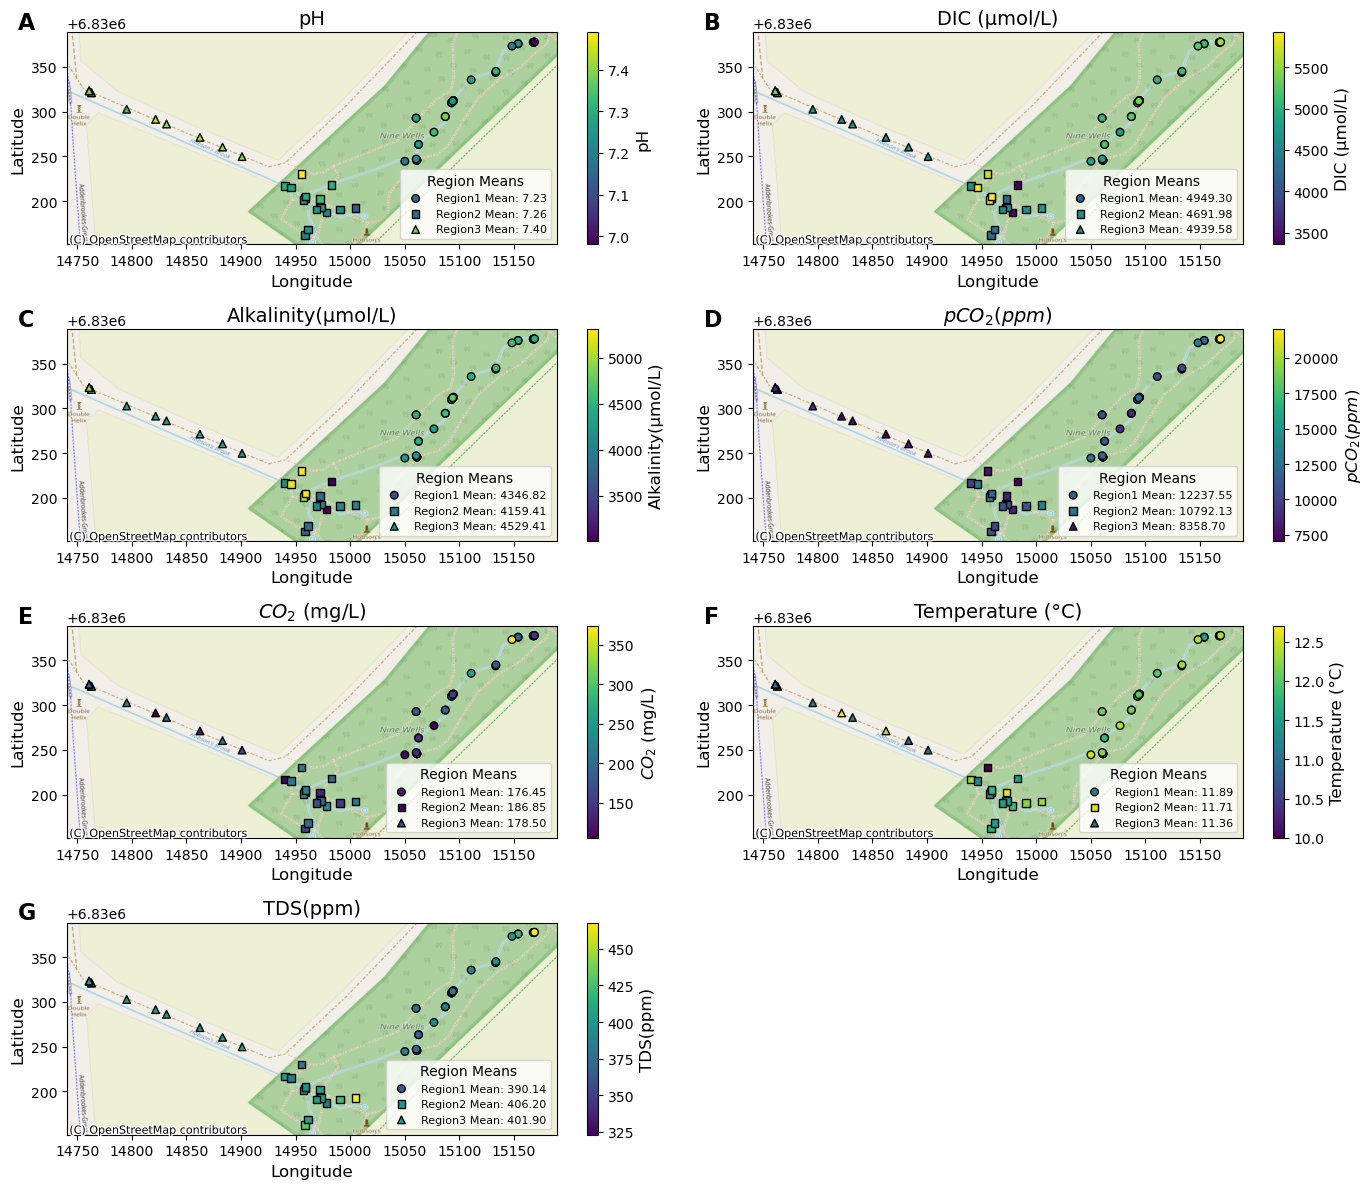

In [129]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as ctx

units = {
    'pH': '',
    'DIC': 'µmol/L',
    'Alkalinity (µmol/L)': 'µmol/L',
    'pCO2': 'ppm',
    'CO2 (mg/L)': 'mg/L',
    'Temp': '°C',
    'TDS (ppm)': 'ppm'
}

# List of variables to plot
variables = ['pH', 'DIC', 'Alkalinity (µmol/L)', 'pCO2', 'CO2 (mg/L)','Temp', 'TDS (ppm)']
titles = {
    'pH': 'pH',
    'DIC': 'DIC (µmol/L)',
    'Alkalinity (µmol/L)': 'Alkalinity(µmol/L)',
    'pCO2': '$pCO_2(ppm)$', 
    'CO2 (mg/L)': '$CO_2$ (mg/L)',  
    'Temp': 'Temperature (°C)',
    'TDS (ppm)': 'TDS(ppm)'
}

region_shapes = {
    'Region1': 'o',  # Circle
    'Region2': 's',  # Square
    'Region3': '^'   # Triangle
}

# Subplot labels
subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F','G']

# Define thresholds for outlier removal (adjust based on your data distribution)
DIC_threshold = (all_data['DIC'].quantile(0.01), all_data['DIC'].quantile(0.99))
Alkalinity_threshold = (all_data['Alkalinity (µmol/L)'].quantile(0.01), all_data['Alkalinity (µmol/L)'].quantile(0.99))
CO2_threshold = (all_data['CO2 (mg/L)'].quantile(0.01), all_data['CO2 (mg/L)'].quantile(0.99))

# Filter data to remove outliers
filtered_data = all_data[
    (all_data['DIC'] >= DIC_threshold[0]) & (all_data['DIC'] <= DIC_threshold[1]) &
    (all_data['Alkalinity (µmol/L)'] >= Alkalinity_threshold[0]) & 
    (all_data['Alkalinity (µmol/L)'] <= Alkalinity_threshold[1]) &
    (all_data['CO2 (mg/L)'] >= CO2_threshold[0]) & (all_data['CO2 (mg/L)'] <= CO2_threshold[1])
]

# Set up subplots for all variables on one figure
fig, axes = plt.subplots(4, 2, figsize=(14, 12))  # Adjust rows/cols based on the number of variables
axes = axes.flatten()

for i, variable in enumerate(variables):
    ax = axes[i]
    
    # Add subplot label
    ax.text(-0.1, 1.1, subplot_labels[i], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')

    # Set the value range for color mapping
    vmin, vmax = filtered_data[variable].min(), filtered_data[variable].max()
    cmap = plt.cm.viridis

    # Plot data points for each region
    for region, shape in region_shapes.items():
        region_data = filtered_data[filtered_data['Region'] == region]
        sc = ax.scatter(
            region_data.geometry.x, region_data.geometry.y,
            c=region_data[variable],  # Use the variable for color
            cmap=cmap,
            vmin=vmin, vmax=vmax,
            edgecolor='k',
            marker=shape,
            s=30,
            label=f'{region} Mean: {region_data[variable].mean():.2f}'
        )

    # Add basemap
    ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
    # Add colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # Required to generate the colorbar
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(titles[variable], fontsize=12)  
    
    # Add legend with region means
    ax.legend(title='Region Means', fontsize=8, loc='lower right', frameon=True)

    # Add title and axis labels
    ax.set_title(f'{titles[variable]}', fontsize=14)
    ax.set_xlabel('Longitude', fontsize=12)  
    ax.set_ylabel('Latitude', fontsize=12)  

# Hide unused subplots if the number of variables is less than grid size
for j in range(len(variables), len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('Region_Plot_with_Labels.png', dpi=300, bbox_inches='tight')
plt.show()


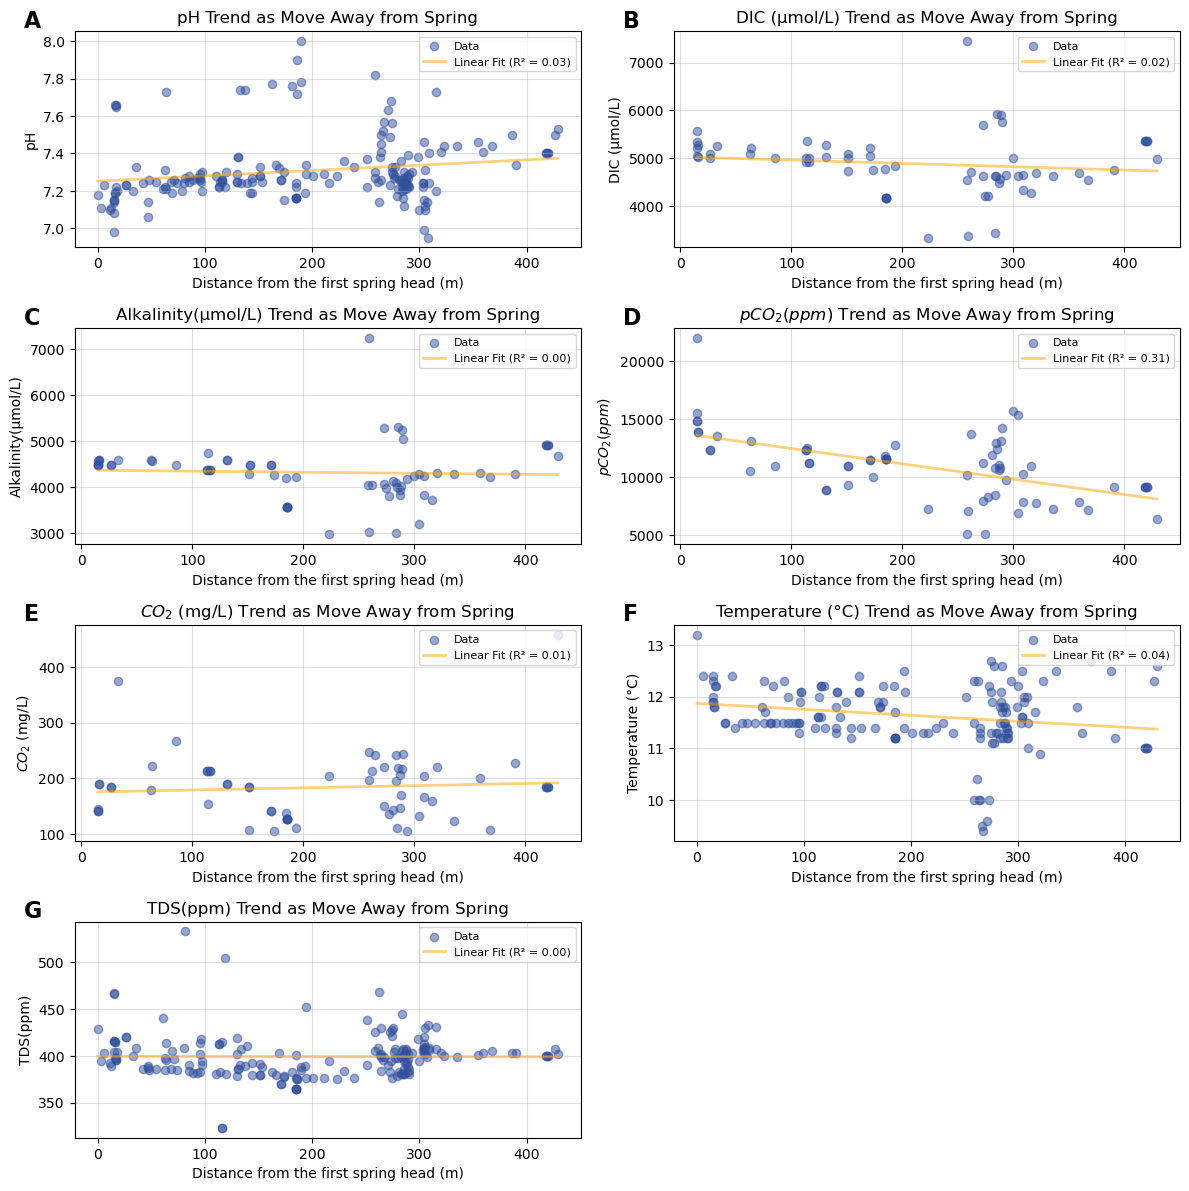

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from shapely.geometry import Point

# Find the source point (the point with the maximum x-coordinate)
source_point = all_data.geometry.loc[all_data.geometry.x.idxmax()]

# Calculate the distance of each point from the source point
all_data['Distance_from_Source'] = all_data.geometry.apply(
    lambda point: source_point.distance(point)
)

# Sort the data by distance from the source point
sorted_data = all_data.sort_values(by='Distance_from_Source')

# Define variables and titles
variables = ['pH', 'DIC', 'Alkalinity (µmol/L)', 'pCO2', 'CO2 (mg/L)', 'Temp', 'TDS (ppm)']
titles = {
    'pH': 'pH',
    'DIC': 'DIC (µmol/L)',
    'Alkalinity (µmol/L)': 'Alkalinity(µmol/L)',
    'pCO2': '$pCO_2(ppm)$',  # Format as LaTeX
    'CO2 (mg/L)': '$CO_2$ (mg/L)',  # Format as LaTeX
    'Temp': 'Temperature (°C)',
    'TDS (ppm)': 'TDS(ppm)'
}

# Set up the figure
fig, axes = plt.subplots(4, 2, figsize=(12, 12))  # Adjust rows/cols based on the number of variables
axes = axes.flatten()
subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

for idx, variable in enumerate(variables):
    ax = axes[idx]

    # Extract distance and variable data, and clean NaN and inf values
    distance = sorted_data['Distance_from_Source'].values
    values = sorted_data[variable].values
    mask = np.isfinite(distance) & np.isfinite(values)  # Filter out NaN and inf values
    distance_cleaned = distance[mask]
    values_cleaned = values[mask]

    # Create a linear regression model
    if len(distance_cleaned) > 1:  # At least two points are required
        reg = LinearRegression()
        reg.fit(distance_cleaned.reshape(-1, 1), values_cleaned)

        # Fit the line
        x_fit = np.linspace(distance_cleaned.min(), distance_cleaned.max(), 500)
        y_fit = reg.predict(x_fit.reshape(-1, 1))

        # Plot the data points and the fitted line
        ax.scatter(distance_cleaned, values_cleaned, label='Data', color='#304f9e', alpha=0.5)
        ax.plot(x_fit, y_fit, label=f'Linear Fit (R² = {reg.score(distance_cleaned.reshape(-1, 1), values_cleaned):.2f})', color='orange', alpha=0.5, linewidth=2)

        # Add titles and labels
        ax.set_xlabel('Distance from the first spring head (m)', fontsize=10)
        ax.set_ylabel(titles[variable], fontsize=10)
        ax.set_title(f'{titles[variable]} Trend as Move Away from Spring', fontsize=12)
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(alpha=0.4)
    # Add subplot labels
    ax.text(-0.1, 1.1, subplot_labels[idx], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')

# Hide unused subplots
for j in range(len(variables), len(axes)):
    axes[j].set_visible(False)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('River_Variables_Trend.png', dpi=300, bbox_inches='tight')
plt.show()

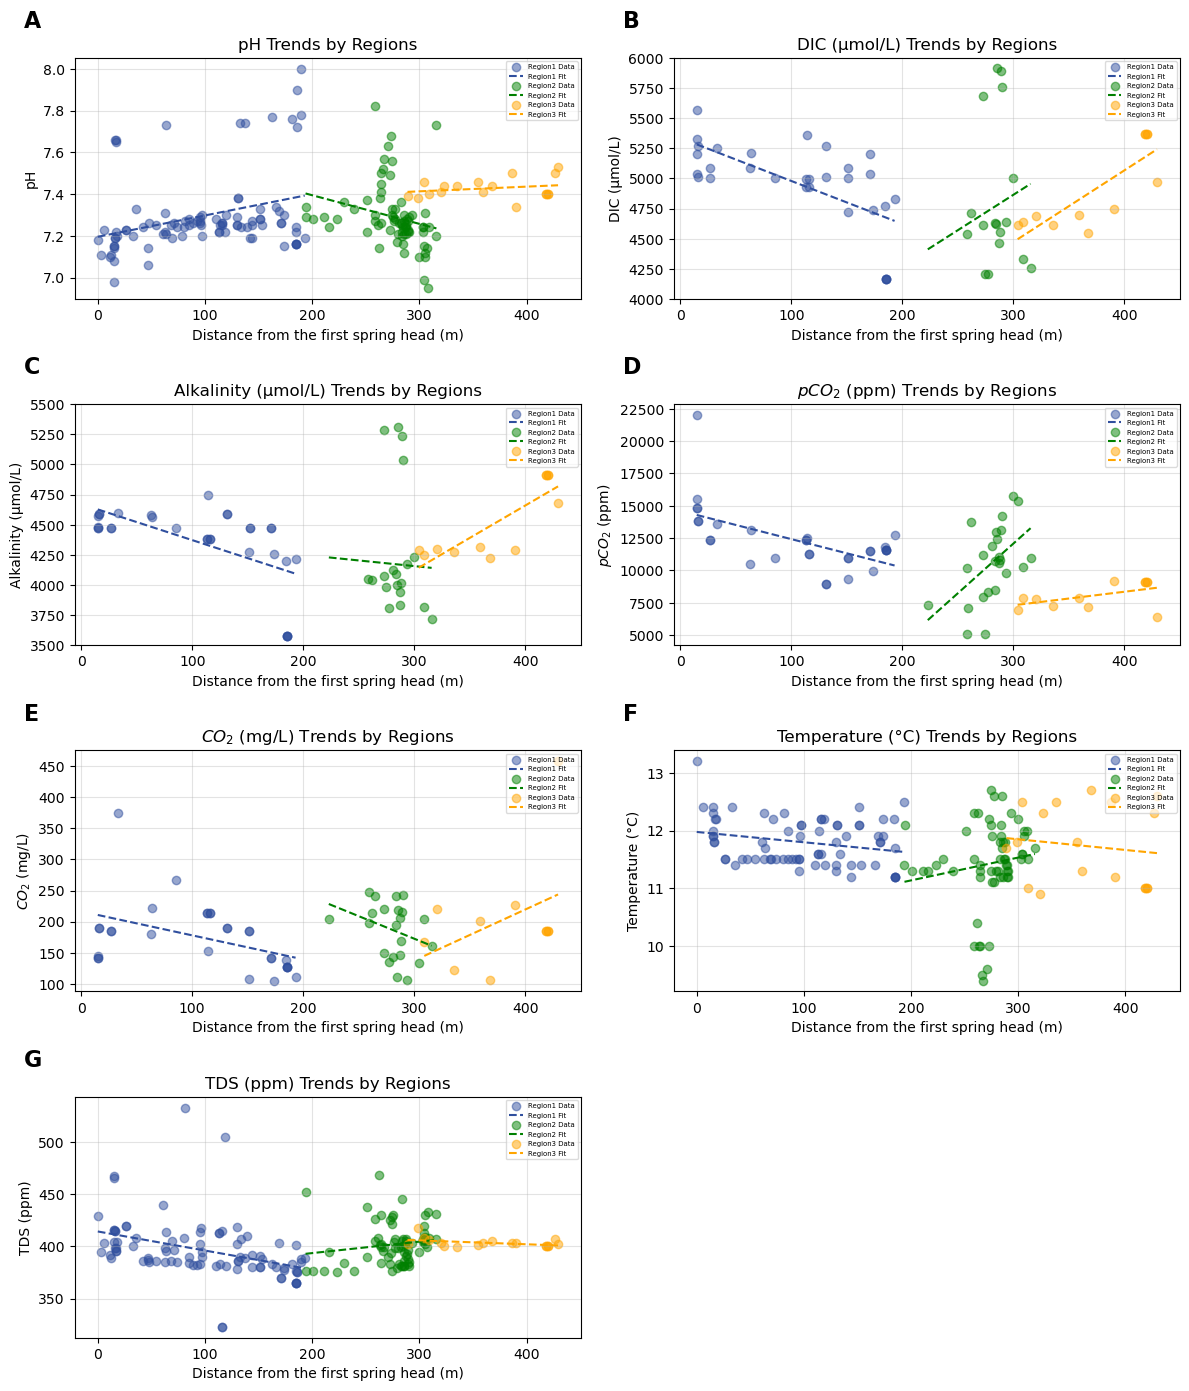

In [128]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the linear model for fitting
def linear_model(x, a, b):
    return a * x + b

# Variables and their corresponding units
variables = ['pH', 'DIC', 'Alkalinity (µmol/L)', 'pCO2', 'CO2 (mg/L)','Temp', 'TDS (ppm)']
units = {
    'pH': '',
    'DIC': 'µmol/L',
    'Alkalinity (µmol/L)': 'µmol/L',
    'pCO2': 'ppm',
    'CO2 (mg/L)': 'mg/L',
    'Temp': 'Temperature (°C)',
    'TDS (ppm)': 'ppm'
}
titles = {
    'pH': 'pH',
    'DIC': 'DIC (µmol/L)',
    'Alkalinity (µmol/L)': 'Alkalinity (µmol/L)',
    'pCO2': '$pCO_2$ (ppm)',
    'CO2 (mg/L)': '$CO_2$ (mg/L)',
    'Temp': 'Temperature (°C)',
    'TDS (ppm)': 'TDS (ppm)'
}

# Define custom y-axis limits for specific variables
y_limits = {
    'DIC': (4000, 6000),  # Adjusted y-axis range for DIC
    'Alkalinity (µmol/L)': (3500, 5500)  # Adjusted y-axis range for Alkalinity
}

region_colors = {
    'Region1': '#304f9e',
    'Region2': 'green',
    'Region3': 'orange'
}

# Set up subplots (3 rows, 2 columns)
n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 14))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten axes for easy indexing

subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F','G',]

# Loop through variables and create subplots
for i, variable in enumerate(variables):
    ax = axes[i]
    ax.text(-0.1, 1.2, subplot_labels[i], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')

    # Iterate through each region
    for region, color in region_colors.items():
        # Filter data for the current region
        region_data = all_data[all_data['Region'] == region]
        distance = region_data['Distance_from_Source'].values
        values = region_data[variable].values

        # Clean NaN and inf values
        mask = np.isfinite(distance) & np.isfinite(values)
        distance_cleaned = distance[mask]
        values_cleaned = values[mask]

        if len(distance_cleaned) > 0:  # Ensure there is enough data for fitting
            try:
                # Fit data to the linear model
                popt, pcov = curve_fit(linear_model, distance_cleaned, values_cleaned)
                
                # Generate the fit curve
                x_fit = np.linspace(distance_cleaned.min(), distance_cleaned.max(), 500)
                y_fit = linear_model(x_fit, *popt)
                
                # Plot scatter and fit line
                ax.scatter(distance_cleaned, values_cleaned, label=f'{region} Data', color=color, alpha=0.5)
                ax.plot(x_fit, y_fit, label=f'{region} Fit', color=color, linestyle='--')
            except Exception as e:
                print(f"Fitting failed for {region} on {variable}: {e}")
                # Plot scatter only if fitting fails
                ax.scatter(distance_cleaned, values_cleaned, label=f'{region} Data', color=color, alpha=0.5)

    # Customize each subplot
    unit = units.get(variable, '')
    ax.set_xlabel('Distance from the first spring head (m)', fontsize=10)
    ax.set_ylabel(f'{titles[variable]}', fontsize=10)  # Use formatted title with unit
    ax.set_title(f'{titles[variable]} Trends by Regions', fontsize=12)
    ax.legend(fontsize=5,
              loc='upper right',  
              frameon=True,       
              framealpha=0.7)
    ax.grid(alpha=0.35)
    
    # Apply custom y-axis limits if specified
    if variable in y_limits:
        ax.set_ylim(y_limits[variable])

# Hide unused subplots if any
for j in range(len(variables), len(axes)):
    axes[j].set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('trend_adjusted.png', dpi=300, bbox_inches='tight')
plt.show()


In [69]:
# Attempt to convert 'TDS (ppm)' to numeric, non-convertible values will be set to NaN
oct_data['TDS (ppm)'] = pd.to_numeric(oct_data['TDS (ppm)'], errors='coerce')

# Check if there are any NaN values
if oct_data['TDS (ppm)'].isna().any():
    print("Warning: Some TDS (ppm) values were non-numeric and have been set to NaN.")
    print(oct_data[oct_data['TDS (ppm)'].isna()])

# Determine vmin and vmax
vmin, vmax = oct_data['TDS (ppm)'].min(), oct_data['TDS (ppm)'].max()

# Print debugging information
print(f"TDS (ppm) range: min = {vmin}, max = {vmax}")


       pH        SampleID  Temp  EC                    Date  \
152  7.19  SAMPLE2,371PPM   NaN NaN 2024-10-22 11:00:27.785   
171  7.19            None   NaN NaN 2024-10-22 11:01:23.179   
175  7.20            None   NaN NaN 2024-10-22 11:20:32.092   

                          geometry Group  Alkalinity (µmol/L)  CO2 (mg/L)  \
152  POINT (15080.274 6830285.463)   NaN                  NaN         NaN   
171  POINT (15082.599 6830281.648)   NaN                  NaN         NaN   
175   POINT (15111.531 6830345.21)   NaN                  NaN         NaN   

    Dataset Corrected alkalinity (Y/N)  TDS (ppm)  pCO2  DIC   Region  \
152     NaN                        NaN        NaN   NaN  NaN  Region1   
171     NaN                        NaN        NaN   NaN  NaN  Region1   
175     NaN                        NaN        NaN   NaN  NaN  Region1   

      Date_only  Cluster  
152  2024-10-22       -1  
171  2024-10-22       -1  
175  2024-10-22       -1  
TDS (ppm) range: min = 375.0, max = 5

In [70]:
# Attempt to convert 'TDS (ppm)' to numeric, non-convertible values will be set to NaN
nov_data['TDS (ppm)'] = pd.to_numeric(nov_data['TDS (ppm)'], errors='coerce')

# Check if there are any NaN values
if nov_data['TDS (ppm)'].isna().any():
    print("Warning: Some TDS (ppm) values were non-numeric and have been set to NaN.")
    print(nov_data[nov_data['TDS (ppm)'].isna()])

# Determine vmin and vmax
vmin, vmax = nov_data['TDS (ppm)'].min(), nov_data['TDS (ppm)'].max()

# Print debugging information
print(f"TDS (ppm) range: min = {vmin}, max = {vmax}")


     pH    SampleID  Temp  EC                    Date  \
34  7.3       AOJE9  11.5 NaN 2024-11-12 10:59:19.598   
65  NaN  CO2-FLUX-1   NaN NaN 2024-11-12 10:30:22.153   
66  NaN  CO2-FLUX-2   NaN NaN 2024-11-12 11:30:14.424   
67  NaN  CO2-FLUX-3   NaN NaN 2024-11-12 12:00:54.602   
68  NaN  CO2-FLUX-4   NaN NaN 2024-11-12 12:09:21.673   

                         geometry Group  Alkalinity (µmol/L)  CO2 (mg/L)  \
34  POINT (14983.039 6830218.095)  AOJE            3011.5252       197.7   
65  POINT (14966.414 6830153.454)   NaN                  NaN         NaN   
66  POINT (14966.953 6830169.503)   NaN                  NaN         NaN   
67  POINT (14805.088 6830288.887)   NaN                  NaN         NaN   
68   POINT (14984.584 6830218.76)   NaN                  NaN         NaN   

   Dataset Corrected alkalinity (Y/N)  TDS (ppm)         pCO2          DIC  \
34     Nov                          y        NaN  7055.203555  3360.985582   
65     NaN                        NaN       

/var/folders/bp/z1dm6g75717g8kp117hv2ykr0000gn/T/ipykernel_1009/2780827444.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/bp/z1dm6g75717g8kp117hv2ykr0000gn/T/ipykernel_1009/2780827444.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/bp/z1dm6g75717g8kp117hv2ykr0000gn/T/ipykernel_1009/2780827444.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/bp/z1dm6g75717g8kp117hv2ykr0000gn/T/ipykernel_1009/2780827444.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

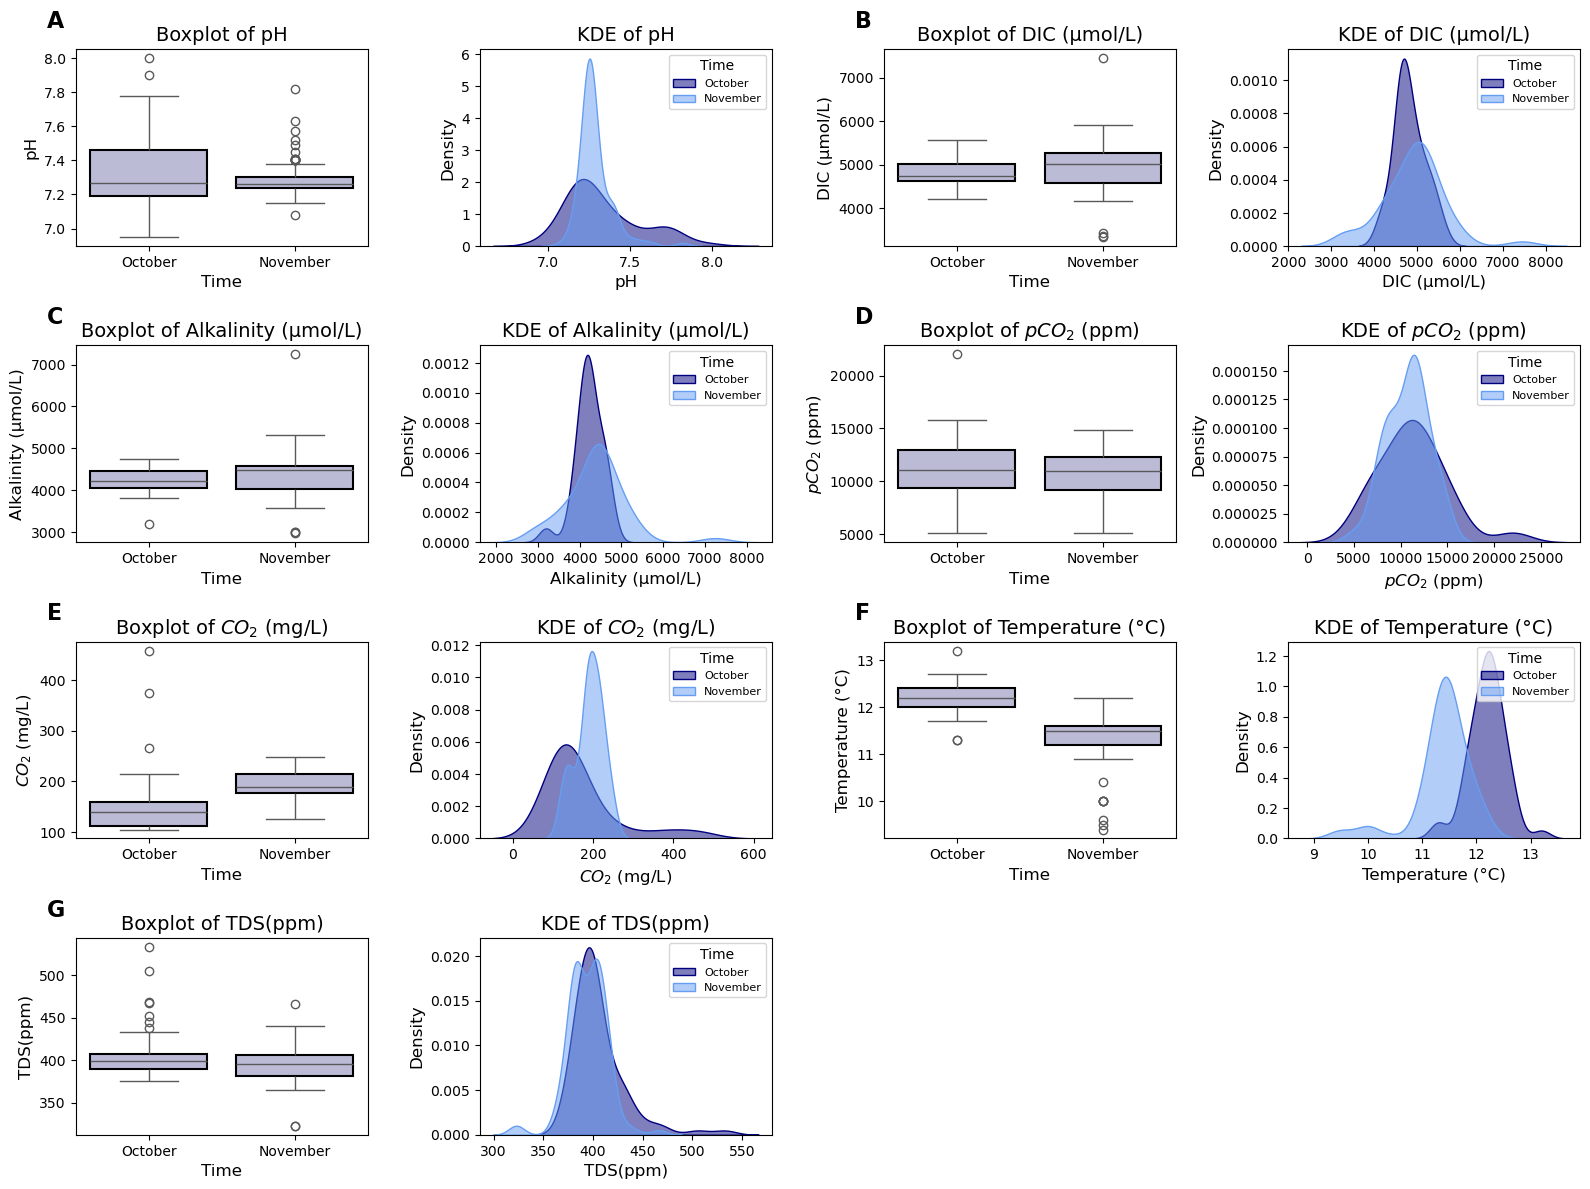

In [138]:
# Ensure 'Time' is of type string
oct_data['Time'] = 'October'
nov_data['Time'] = 'November'

# List of variables to plot
variables = ['pH', 'DIC', 'Alkalinity (µmol/L)', 'pCO2',  'CO2 (mg/L)', 'Temp','TDS (ppm)']
subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F','G']  # Labels for each pair of plots

# Define a dictionary for variable titles and units
titles = {
    'pH': 'pH',
    'Alkalinity (µmol/L)': 'Alkalinity (µmol/L)',
    'DIC': 'DIC (µmol/L)',
    'CO2 (mg/L)': '$CO_2$ (mg/L)',
    'pCO2': '$pCO_2$ (ppm)',
    'Temp': 'Temperature (°C)',
    'TDS (ppm)': 'TDS(ppm)',
}

# Set up a figure with 3 rows and 4 columns (3x4 layout)
fig, axes = plt.subplots(4, 4, figsize=(16, 12))  # Adjust figure size for the layout
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through variables and create plots
for i, variable in enumerate(variables):
    # Combine data for the current variable
    combined_data = pd.concat([oct_data[[variable, 'Time']], nov_data[[variable, 'Time']]])

    # Drop NaN values and ensure 'Time' is string
    combined_data = combined_data.dropna(subset=[variable, 'Time'])
    combined_data['Time'] = combined_data['Time'].astype(str)

    # Add subplot label to the boxplot (left column for each variable)
    axes[i * 2].text(-0.1, 1.2, subplot_labels[i], transform=axes[i * 2].transAxes,
                     fontsize=16, fontweight='bold', va='top', ha='left')

    # Boxplot (Left Column)
    sns.boxplot(
        data=combined_data, x='Time', y=variable,
        ax=axes[i * 2], palette='Set2',
        boxprops={'facecolor': '#bbbbd6', 'edgecolor': 'black', 'linewidth': 1.5}
    )
    axes[i * 2].set_title(f'Boxplot of {titles[variable]}', fontsize=14)  # Use formatted title
    axes[i * 2].set_xlabel('Time', fontsize=12)
    axes[i * 2].set_ylabel(titles[variable], fontsize=12)  # Use formatted title

    # KDE plot (Right Column)
    sns.kdeplot(data=oct_data[variable].dropna(), fill=True, color='#00007f', label='October', alpha=0.5, ax=axes[i * 2 + 1])
    sns.kdeplot(data=nov_data[variable].dropna(), fill=True, color='#669ef2', label='November', alpha=0.5, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'KDE of {titles[variable]}', fontsize=14)  # Use formatted title
    axes[i * 2 + 1].set_xlabel(titles[variable], fontsize=12)  # Use formatted title
    axes[i * 2 + 1].set_ylabel('Density', fontsize=12)
    axes[i * 2 + 1].legend(title='Time', loc= 'upper right', fontsize=8)

# Hide unused subplots (last two in the 3x4 grid)
for j in range(len(variables) * 2, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('3x4_plot_with_labels.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x600 with 0 Axes>

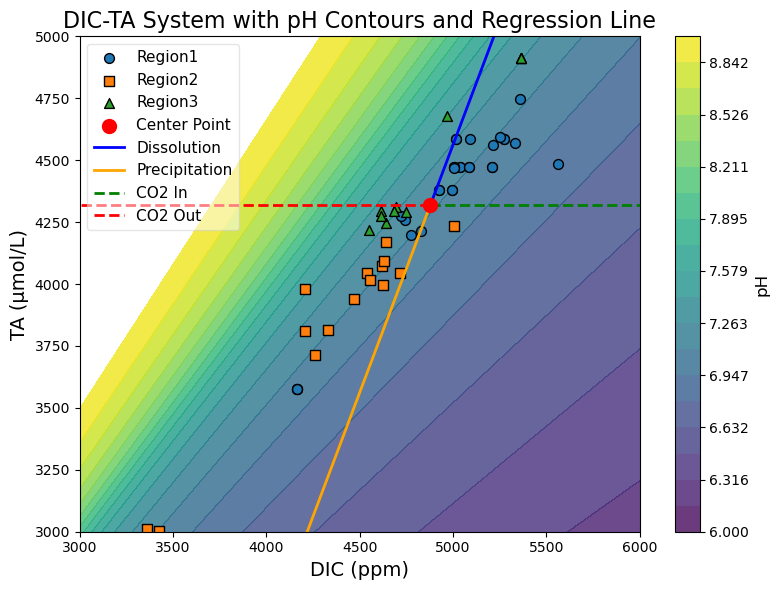

In [72]:
# Set extended ranges for DIC and TA
TA = np.linspace(2000, 5000, 200)  # Extend the range for TA
DIC = np.linspace(2000, 6500, 200)  # Extend the range for DIC
xTA, yDIC = np.meshgrid(TA, DIC)

# Calculate the carbon system
cs = cb.Csys(TA=xTA, DIC=yDIC, S_in=0, T_in=10)
cs_data = cb.Csys(TA=all_data['Alkalinity (µmol/L)'], pHNBS=all_data['pH'], S_in=0, T_in=10)

# Calculate the center point
center_DIC = all_data.DIC.mean()
center_TA = np.nanmean(all_data['Alkalinity (µmol/L)'])

# Create the plot canvas
plt.figure(figsize=(8, 6))  # Set a larger figure size

# Use pHtot data
pH_values = cs.pHtot  # Or try using cs.pHNBS
contour_levels = np.linspace(6, 9, 20)  # Set contour levels for pH

# Plot the filled contour (color regions) for DIC-TA using pH values
plt.figure(figsize=(8, 6))
contourf = plt.contourf(cs.DIC, cs.TA, pH_values, levels=contour_levels, cmap='viridis', alpha=0.8)
cbar = plt.colorbar(contourf)
cbar.set_label('pH', fontsize=12)

# Plot scatter points grouped by the Region column
region_shapes = {
    'Region1': 'o',  # Replace with actual Region names
    'Region2': 's',
    'Region3': '^',
}

for region, shape in region_shapes.items():
    region_data = all_data[all_data['Region'] == region]
    plt.scatter(
        region_data['DIC'], region_data['Alkalinity (µmol/L)'],
        label=region,
        marker=shape,
        s=50,
        edgecolor='k'
    )

# Mark the center point
plt.scatter(center_DIC, center_TA, color='red', zorder=999, label='Center Point', s=100)

# Vectors for dissolution and precipitation
dDIC = 2000
stoic_calc = 2
stoic_resp = 0

# Use the center point as the starting point
plt.plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_calc], label='Dissolution', color='blue', linewidth=2)
plt.plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_calc], label='Precipitation', color='orange', linewidth=2)

# Vectors for CO2 in and CO2 out
plt.plot([center_DIC, center_DIC + dDIC], [center_TA, center_TA + dDIC * stoic_resp], label='CO2 In', color='green', linestyle='--', linewidth=2)
plt.plot([center_DIC, center_DIC - dDIC], [center_TA, center_TA - dDIC * stoic_resp], label='CO2 Out', color='red', linestyle='--', linewidth=2)

# Set the legend
plt.legend(fontsize=11, loc='upper left', frameon=True, framealpha=0.5)

# Set axis limits
plt.xlim(3000, 6000)
plt.ylim(3000, 5000)

# Set axis labels
plt.xlabel('DIC (ppm)', fontsize=14)
plt.ylabel('TA (µmol/L)', fontsize=14)

# Beautify the chart
plt.title('DIC-TA System with pH Contours and Regression Line', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()